In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys
import os

# Add project root to path
project_root = os.getcwd()
sys.path.insert(0, project_root)

# Import your network modules
from src.spiking_network import SpikingRNN
from src.rng_utils import get_rng

# Set matplotlib parameters for Nature specifications
plt.rcParams['pdf.fonttype'] = 42  # Ensures TrueType fonts
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica']
plt.rcParams['font.size'] = 7  # Maximum text size per Nature guidelines
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['xtick.major.size'] = 2.5
plt.rcParams['ytick.major.size'] = 2.5

# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def create_spike_matrix(spike_list, n_neurons, duration, step_size):
    """Create spike matrix with proper rounding to avoid binning issues"""
    n_steps = int(np.ceil(duration / step_size))
    spike_matrix = np.zeros((n_steps, n_neurons))
    
    for spike_time, neuron_id in spike_list:
        time_bin = int(round(spike_time / step_size))
        if 0 <= time_bin < n_steps and 0 <= neuron_id < n_neurons:
            spike_matrix[time_bin, neuron_id] += 1
    
    return spike_matrix

def compute_participation_ratio(spike_matrix, transient_time, step_size):
    """Compute participation ratio from spike matrix"""
    # Discard transient period
    transient_bins = int(transient_time / step_size)
    spike_matrix_analysis = spike_matrix[transient_bins:, :]
    
    if spike_matrix_analysis.size == 0:
        return 0.0
    
    # Convert to firing rates (Hz)
    firing_rate_matrix = spike_matrix_analysis / (step_size / 1000.0)
    
    # Transpose to get (neurons x time_bins) for covariance
    firing_rate_matrix = firing_rate_matrix.T
    
    # Compute covariance matrix
    mean_rates = np.mean(firing_rate_matrix, axis=1, keepdims=True)
    centered_rates = firing_rate_matrix - mean_rates
    
    # Covariance matrix
    cov_matrix = np.cov(centered_rates)
    
    # Compute eigenvalues
    eigenvalues = np.linalg.eigvalsh(cov_matrix)
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    if len(eigenvalues) == 0:
        return 0.0
    
    # Participation ratio
    pr = (np.sum(eigenvalues) ** 2) / np.sum(eigenvalues ** 2)
    
    return pr

def get_firing_rates_from_matrix(spike_matrix, transient_time, step_size):
    """Get per-neuron firing rates from spike matrix, excluding transient period"""
    transient_bins = int(transient_time / step_size)
    spike_matrix_analysis = spike_matrix[transient_bins:, :]
    
    # Mean over time gives spikes per bin for each neuron
    # Divide by time duration to get rate in Hz
    analysis_duration = (spike_matrix_analysis.shape[0] * step_size) / 1000.0  # in seconds
    firing_rates = np.mean(spike_matrix_analysis, axis=0) / (step_size / 1000.0)
    
    return firing_rates

def get_population_rate_from_matrix(spike_matrix, step_size):
    """Get population firing rate over time from spike matrix"""
    # Mean over neurons (axis=1) gives average spikes per time bin
    # Convert to Hz
    pop_rate = np.mean(spike_matrix, axis=1) / (step_size / 1000.0)
    time_bins = np.arange(spike_matrix.shape[0]) * step_size
    
    return time_bins, pop_rate

def compute_ei_balance(network, neuron_id):
    """Compute E-I balance for a single neuron"""
    # Get all incoming weights to this neuron from the recurrent weight matrix
    # weight_matrix is sparse, shape (n_target, n_source) = (n_neurons, n_neurons)
    # weight_matrix[i, j] is weight from neuron j to neuron i
    
    if network.recurrent_synapses.weight_matrix is None:
        return 0.0
    
    # Get incoming weights (column neuron_id, all rows that project to this neuron)
    incoming_weights = network.recurrent_synapses.weight_matrix[:, neuron_id].toarray().flatten()
    
    # Separate excitatory (positive) and inhibitory (negative) weights
    exc_weights = incoming_weights[incoming_weights > 0]
    inh_weights = incoming_weights[incoming_weights < 0]
    
    # E-I balance = sum(E) - |sum(I)|
    e_sum = np.sum(exc_weights)
    i_sum = np.abs(np.sum(inh_weights))  # Take absolute value of the sum
    
    ei_balance = e_sum - i_sum
    
    return ei_balance

# =============================================================================
# SIMULATION PARAMETERS
# =============================================================================

n_neurons = 1000
dt = 0.1
duration = 500.0 +300
transient_time = 200.0 +300
v_th_std = 0
trial_id = 1

network_params = {
    'v_th_distribution': 'normal',
    'static_input_strength': 10.0,
    'dynamic_input_strength': 1.0,
    'readout_weight_scale': 1.0
}

# Number of realizations for panel D (dimensionality std)
n_realizations = 20

# =============================================================================
# STEP 1: RUN 1 NETWORK REALIZATION FOR PANEL B
# =============================================================================

print("="*80)
print("STEP 1: RUNNING 1 NETWORK REALIZATION FOR PANEL B")
print("="*80)

g_std_main = 1.0
static_input_rate_main = 30.0
step_size = 0.1  # Same as dt for spike matrix

session_id = 100
print(f"\nRealization (session_id={session_id})...")

network = SpikingRNN(n_neurons=n_neurons, dt=dt, synaptic_mode="filter",
                    static_input_mode="common_tonic")
network.initialize_network(session_id, v_th_std, g_std_main, **network_params)

spike_times_main = network.simulate_network_dynamics(
    session_id=session_id,
    v_th_std=v_th_std,
    g_std=g_std_main,
    trial_id=trial_id,
    duration=duration,
    static_input_rate=static_input_rate_main
)

print(f"   Total spikes: {len(spike_times_main)}")

# Create spike matrix for panel B
spike_matrix_main = create_spike_matrix(spike_times_main, n_neurons, duration, step_size)
print(f"   Spike matrix shape: {spike_matrix_main.shape}")

# Extract firing rates
firing_rates_main = get_firing_rates_from_matrix(spike_matrix_main, transient_time, step_size)
print(f"   Mean firing rate: {np.mean(firing_rates_main):.2f} Hz")
print(f"   Std firing rate: {np.std(firing_rates_main):.2f} Hz")

# =============================================================================
# STEP 2: RUN SIMULATIONS FOR PANELS C AND D
# =============================================================================

print("\n" + "="*80)
print("STEP 2: SIMULATIONS FOR PANELS C AND D")
print("="*80)

g_values = np.linspace(0.4, 2, 9)
static_input_rates = [30, 31, 32, 33, 34, 35]
bin_size_pr = 2.0  # 2ms bins for participation ratio

# Storage for panel C (mean and std of firing rates) - single realization
firing_rate_means_c = {rate: [] for rate in static_input_rates}
firing_rate_stds_c = {rate: [] for rate in static_input_rates}

# Storage for panel D (dimensionality) - 20 realizations for mean ± std
dimensionality_data = {rate: {g: [] for g in g_values} for rate in static_input_rates}

total_sims = len(g_values) * len(static_input_rates) * n_realizations
sim_count = 0

for g_val in g_values:
    for static_rate in static_input_rates:
        print(f"\n   g={g_val:.2f}, static_rate={static_rate} Hz")
        
        for real_idx in range(n_realizations):
            sim_count += 1
            session_id = 300 + sim_count
            
            print(f"      [{sim_count}/{total_sims}] Realization {real_idx+1}/{n_realizations}...", end=" ")
            
            network_temp = SpikingRNN(n_neurons=n_neurons, dt=dt, synaptic_mode="filter",
                                     static_input_mode="common_tonic")
            network_temp.initialize_network(session_id, v_th_std, g_val, **network_params)
            
            spikes_temp = network_temp.simulate_network_dynamics(
                session_id=session_id,
                v_th_std=v_th_std,
                g_std=g_val,
                trial_id=trial_id,
                duration=duration,
                static_input_rate=static_rate
            )
            
            # Create spike matrix with 2ms bins
            spike_matrix_temp = create_spike_matrix(spikes_temp, n_neurons, duration, bin_size_pr)
            
            # Panel C: mean and std of firing rates across neurons (only first realization)
            if real_idx == 0:
                firing_rates_temp = get_firing_rates_from_matrix(spike_matrix_temp, transient_time, bin_size_pr)
                mean_rate = np.mean(firing_rates_temp)
                std_rate = np.std(firing_rates_temp)
                firing_rate_means_c[static_rate].append(mean_rate)
                firing_rate_stds_c[static_rate].append(std_rate)
                print(f"Mean rate={mean_rate:.2f} Hz, Std={std_rate:.2f} Hz, ", end="")
            
            # Panel D: participation ratio (all realizations)
            pr = compute_participation_ratio(spike_matrix_temp, transient_time, bin_size_pr)
            dimensionality_data[static_rate][g_val].append(pr)
            print(f"PR={pr:.2f}")

print("\n" + "="*80)
print("ALL SIMULATIONS COMPLETE!")
print("="*80)

STEP 1: RUNNING 1 NETWORK REALIZATION FOR PANEL B

Realization (session_id=100)...
   Total spikes: 14970
   Spike matrix shape: (8000, 1000)
   Mean firing rate: 19.57 Hz
   Std firing rate: 2.79 Hz

STEP 2: SIMULATIONS FOR PANELS C AND D

   g=0.40, static_rate=30 Hz
      [1/1080] Realization 1/20... Mean rate=19.74 Hz, Std=1.55 Hz, PR=78.31
      [2/1080] Realization 2/20... PR=76.55
      [3/1080] Realization 3/20... PR=76.78
      [4/1080] Realization 4/20... PR=76.76
      [5/1080] Realization 5/20... PR=78.51
      [6/1080] Realization 6/20... PR=76.08
      [7/1080] Realization 7/20... PR=78.21
      [8/1080] Realization 8/20... PR=77.81
      [9/1080] Realization 9/20... PR=79.23
      [10/1080] Realization 10/20... PR=77.54
      [11/1080] Realization 11/20... PR=75.94
      [12/1080] Realization 12/20... PR=76.23
      [13/1080] Realization 13/20... PR=77.39
      [14/1080] Realization 14/20... PR=76.83
      [15/1080] Realization 15/20... PR=74.87
      [16/1080] Realizati

In [33]:
# =============================================================================
# SAVE SIMULATION DATA
# =============================================================================

print("\n" + "="*80)
print("SAVING SIMULATION DATA")
print("="*80)

import pickle

simulation_data = {
    'spike_times_main': spike_times_main,
    'spike_matrix_main': spike_matrix_main,
    'firing_rate_means_c': firing_rate_means_c,
    'firing_rate_stds_c': firing_rate_stds_c,
    'dimensionality_data': dimensionality_data,
    'parameters': {
        'g_values': g_values,
        'static_input_rates': static_input_rates,
        'n_neurons': n_neurons,
        'duration': duration,
        'transient_time': transient_time,
        'n_realizations': n_realizations
    }
}

with open('simulation_data.pkl', 'wb') as f:
    pickle.dump(simulation_data, f)

print("Data saved to 'simulation_data.pkl'")


SAVING SIMULATION DATA
Data saved to 'simulation_data.pkl'


In [1]:
# =============================================================================
# STEP 3: LOAD OR RUN SIMULATIONS
# =============================================================================

import pickle
import os

if os.path.exists('simulation_data.pkl'):
    print("\n" + "="*80)
    print("LOADING EXISTING SIMULATION DATA")
    print("="*80)
    
    with open('simulation_data.pkl', 'rb') as f:
        simulation_data = pickle.load(f)
    
    spike_times_main = simulation_data['spike_times_main']
    spike_matrix_main = simulation_data['spike_matrix_main']
    firing_rate_means_c = simulation_data['firing_rate_means_c']
    firing_rate_stds_c = simulation_data['firing_rate_stds_c']
    dimensionality_data = simulation_data['dimensionality_data']
    
    params = simulation_data['parameters']
    g_values = params['g_values']
    static_input_rates = params['static_input_rates']
    n_neurons = params['n_neurons']
    duration = params['duration']
    transient_time = params['transient_time']
    
    print("Data loaded successfully!")
else:
    # Run simulations (your existing STEP 1 and STEP 2 code here)
    pass


LOADING EXISTING SIMULATION DATA
Data loaded successfully!



CREATING FIGURE

Figure saved as 'nature_figure.svg' and 'nature_figure.pdf'

Figure statistics:


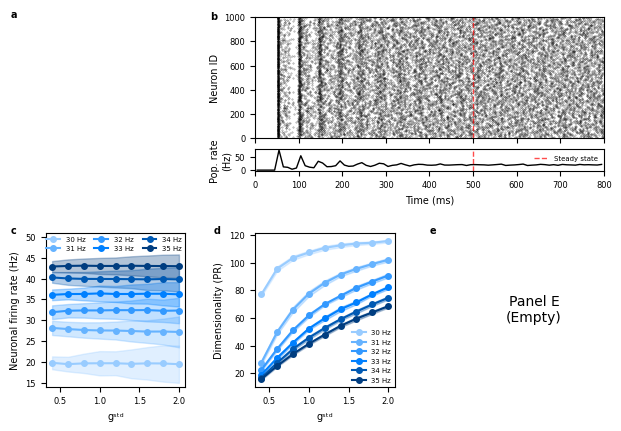

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys
import os
# =============================================================================
# STEP 3: CREATE FIGURE
# =============================================================================

print("\n" + "="*80)
print("CREATING FIGURE")
print("="*80)

# Create figure
fig = plt.figure(figsize=(7.2, 4.8))
main_gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.4, wspace=0.5)

# ROW 1: Cell [0,0] normal, then merged cells [0,1] and [0,2] with two sub-rows (4:1 ratio)
ax_00 = fig.add_subplot(main_gs[0, 0])

row1_gs = gridspec.GridSpecFromSubplotSpec(5, 2, subplot_spec=main_gs[0, 1:3], 
                                            hspace=0.5, wspace=0.1)
ax_01_top = fig.add_subplot(row1_gs[0:4, :])
ax_01_bottom = fig.add_subplot(row1_gs[4, :])

# ROW 2: Normal subplots
ax_10 = fig.add_subplot(main_gs[1, 0])
ax_11 = fig.add_subplot(main_gs[1, 1])
ax_12 = fig.add_subplot(main_gs[1, 2])

# =============================================================================
# PANEL A: Placeholder (you can add your content here)
# =========================================================================

ax_00.set_xlim(0, 1)
ax_00.set_ylim(0, 1)
ax_00.axis('off')
ax_00.text(-0.25, 1.05, 'a', transform=ax_00.transAxes, 
           fontsize=7, fontweight='bold', va='top')

# =============================================================================
# PANEL B TOP: Raster plot
# =============================================================================

times = [s[0] for s in spike_times_main]
neuron_ids = [s[1] for s in spike_times_main]

ax_01_top.scatter(times, neuron_ids, s=0.1, c='black', alpha=0.5, rasterized=True)
ax_01_top.axvline(transient_time, color='red', linestyle='--', linewidth=1, alpha=0.7)
ax_01_top.set_ylabel('Neuron ID', fontsize=7, verticalalignment='top', labelpad=10)
ax_01_top.set_xlim(0, duration)
ax_01_top.set_ylim(0, n_neurons)
ax_01_top.tick_params(labelsize=6, labelbottom=False)
ax_01_top.text(-0.13, 1.05, 'b', transform=ax_01_top.transAxes, 
               fontsize=7, fontweight='bold', va='top')

# =============================================================================
# PANEL B BOTTOM: Population rate
# =============================================================================

# Use 10ms bins for cleaner population rate plot
bin_size_pop = 10.0
bins = np.arange(0, duration + bin_size_pop, bin_size_pop)
spike_counts, _ = np.histogram(times, bins=bins)
firing_rate = spike_counts / (bin_size_pop / 1000.0) / n_neurons
bin_centers = bins[:-1] + bin_size_pop/2

ax_01_bottom.plot(bin_centers, firing_rate, 'k-', linewidth=1)
ax_01_bottom.axvline(transient_time, color='red', linestyle='--', linewidth=1, alpha=0.7, 
                     label='Steady state')
ax_01_bottom.set_xlabel('Time (ms)', fontsize=7)
ax_01_bottom.set_ylabel('Pop. rate\n(Hz)', fontsize=7, verticalalignment='top', labelpad=10)
ax_01_bottom.set_xlim(0, duration)
ax_01_bottom.tick_params(labelsize=6)
ax_01_bottom.legend(fontsize=5, frameon=False, loc='upper right')

# Align y-labels for panel B
fig.align_ylabels([ax_01_top, ax_01_bottom])

# =============================================================================
# PANEL C: Mean firing rate ± std vs g
# =============================================================================

# Blue gradient from light to dark as input strength increases
colors = ['#99CCFF', '#66B3FF', '#3399FF', '#0080FF', '#0059B3', '#003D80']

for idx, static_rate in enumerate(static_input_rates):
    means = np.array(firing_rate_means_c[static_rate])
    stds = np.array(firing_rate_stds_c[static_rate])
    
    ax_10.plot(g_values, means, 'o-', color=colors[idx], linewidth=1.5, 
               markersize=4, label=f'{static_rate} Hz')
    ax_10.fill_between(g_values, means - stds, means + stds, 
                       color=colors[idx], alpha=0.3)

ax_10.set_xlabel('gˢᵗᵈ', fontsize=7)
ax_10.set_ylabel('Neuronal firing rate (Hz)', fontsize=7)
ax_10.set_ylim([14, 51])
ax_10.tick_params(labelsize=6)
ax_10.legend(fontsize=5, frameon=False, loc='best', ncol=3, bbox_to_anchor=(1., 1.), 
             columnspacing=1.3, borderpad=0)
ax_10.text(-0.25, 1.05, 'c', transform=ax_10.transAxes, 
           fontsize=7, fontweight='bold', va='top')

# =============================================================================
# PANEL D: Dimensionality (PR) vs g with std across realizations
# =============================================================================

for idx, static_rate in enumerate(static_input_rates):
    pr_means = []
    pr_stds = []
    
    for g_val in g_values:
        prs = dimensionality_data[static_rate][g_val]
        pr_means.append(np.mean(prs))
        pr_stds.append(np.std(prs))
    
    pr_means = np.array(pr_means)
    pr_stds = np.array(pr_stds)
    
    ax_11.plot(g_values, pr_means, 'o-', color=colors[idx], linewidth=1.5, 
               markersize=4, label=f'{static_rate} Hz')
    ax_11.fill_between(g_values, pr_means - pr_stds, pr_means + pr_stds, 
                       color=colors[idx], alpha=0.3)

ax_11.set_xlabel('gˢᵗᵈ', fontsize=7)
ax_11.set_ylabel('Dimensionality (PR)', fontsize=7)
ax_11.tick_params(labelsize=6)
ax_11.legend(fontsize=5, frameon=False, loc='best', borderpad=0)
ax_11.text(-0.3, 1.05, 'd', transform=ax_11.transAxes, 
           fontsize=7, fontweight='bold', va='top')

# =============================================================================
# PANEL E: Empty for now
# =============================================================================

ax_12.text(0.5, 0.5, 'Panel E\n(Empty)', 
           ha='center', va='center', fontsize=10, transform=ax_12.transAxes)
ax_12.set_xlim(0, 1)
ax_12.set_ylim(0, 1)
ax_12.axis('off')
ax_12.text(-0.25, 1.05, 'e', transform=ax_12.transAxes, 
           fontsize=7, fontweight='bold', va='top')

# =============================================================================
# SAVE FIGURE
# =============================================================================

fig.align_ylabels([ax_01_top, ax_01_bottom])

plt.savefig('nature_figure.svg', format='svg', dpi=450, bbox_inches='tight')
plt.savefig('nature_figure.pdf', format='pdf', dpi=450, bbox_inches='tight')

print("\nFigure saved as 'nature_figure.svg' and 'nature_figure.pdf'")
print("\nFigure statistics:")

plt.show()

In [15]:
channel_colors

array([[0.253935, 0.265254, 0.529983, 1.      ],
       [0.163625, 0.471133, 0.558148, 1.      ],
       [0.134692, 0.658636, 0.517649, 1.      ],
       [0.477504, 0.821444, 0.318195, 1.      ]])

In [16]:
a = channel_colors[1].copy()
b = channel_colors[-1].copy()
channel_colors[-1] = a
channel_colors[1] = b
channel_colors

array([[0.253935, 0.265254, 0.529983, 1.      ],
       [0.477504, 0.821444, 0.318195, 1.      ],
       [0.134692, 0.658636, 0.517649, 1.      ],
       [0.163625, 0.471133, 0.558148, 1.      ]])

GENERATING HD INPUT PATTERNS

Generating pattern with d=1...
Generating pattern with d=4...

Pattern d=1: shape = (3000, 4)
Pattern d=4: shape = (3000, 4)

d=1 - Mean correlation: 1.000
d=4 - Mean correlation: 0.000

CREATING FIGURE

Figure saved as 'nature_hd_encoding_figure.svg' and '.pdf'

All fontsizes comply with Nature guidelines (5-7 pt):
  - Panel labels (a,b,c,d,e,f): 7 pt
  - Axis labels: 7 pt
  - Tick labels: 6 pt
  - Panel C text labels (HD input, etc.): 7 pt


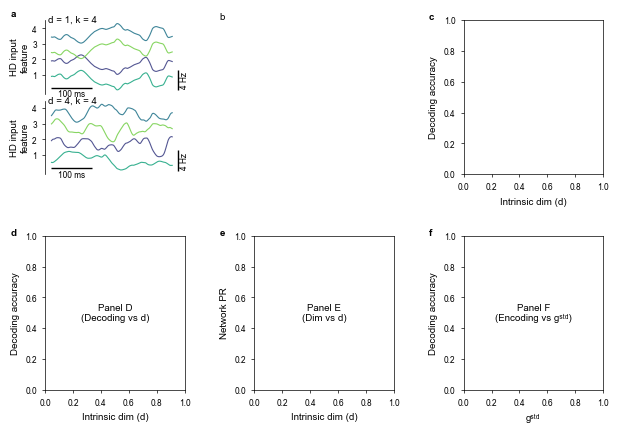

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys
import os

# Add project to path
project_root = os.getcwd()
sys.path.insert(0, project_root)

from src.hd_input import HDInputGenerator

# Set matplotlib parameters for Nature specifications
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica']
plt.rcParams['font.size'] = 7
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['xtick.major.size'] = 2.5
plt.rcParams['ytick.major.size'] = 2.5

# =============================================================================
# GENERATE HD INPUT PATTERNS
# =============================================================================

print("="*80)
print("GENERATING HD INPUT PATTERNS")
print("="*80)

# Parameters
session_id = 120
pattern_id = 0
k = 4  # Embedding dimension
d1 = 1  # Low intrinsic dimensionality
d2 = 4  # High intrinsic dimensionality
dt = 0.1
stimulus_duration = 300.0

# Create generators
gen1 = HDInputGenerator(embed_dim=k, dt=dt, signal_cache_dir='temp_signals_d1')
gen2 = HDInputGenerator(embed_dim=k, dt=dt, signal_cache_dir='temp_signals_d2')

# Generate pattern with d=1
print(f"\nGenerating pattern with d={d1}...")
gen1.initialize_base_input(
    session_id=session_id,
    hd_dim=d1,
    pattern_id=pattern_id,
    rate_rnn_params={
        'n_neurons': 1000,
        'T': 200.0 + stimulus_duration,
        'g': 2.0
    }
)
pattern_d1 = gen1.Y_base.copy() + 2

# Generate pattern with d=4
print(f"Generating pattern with d={d2}...")
gen2.initialize_base_input(
    session_id=session_id,
    hd_dim=d2,
    pattern_id=pattern_id,
    rate_rnn_params={
        'n_neurons': 1000,
        'T': 200.0 + stimulus_duration,
        'g': 2.0
    }
)
pattern_d2 = gen2.Y_base.copy() + 2

print(f"\nPattern d={d1}: shape = {pattern_d1.shape}")
print(f"Pattern d={d2}: shape = {pattern_d2.shape}")

# Time array
time = np.arange(pattern_d1.shape[0]) * dt

# Compute correlations
corr_d1 = np.corrcoef(pattern_d1.T)
corr_d2 = np.corrcoef(pattern_d2.T)
mean_corr_d1 = np.mean(np.abs(corr_d1[np.triu_indices_from(corr_d1, k=1)]))
mean_corr_d2 = np.mean(np.abs(corr_d2[np.triu_indices_from(corr_d2, k=1)]))
print(f"\nd={d1} - Mean correlation: {mean_corr_d1:.3f}")
print(f"d={d2} - Mean correlation: {mean_corr_d2:.3f}")

# =============================================================================
# CREATE FIGURE
# =============================================================================

print("\n" + "="*80)
print("CREATING FIGURE")
print("="*80)

# Create figure (Nature double column width)
fig = plt.figure(figsize=(7.2, 4.8))
main_gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.4, wspace=0.5)

# ROW 2: Three normal panels (D, E, F)
ax_10 = fig.add_subplot(main_gs[1, 0])
ax_11 = fig.add_subplot(main_gs[1, 1])
ax_12 = fig.add_subplot(main_gs[1, 2])

# ROW 1: Panel A (with 2x1 subgrid), Panel B, Panel C
ax_01 = fig.add_subplot(main_gs[0, 1])
ax_02 = fig.add_subplot(main_gs[0, 2])

# =============================================================================
# PANEL A: HD input patterns (KEEP ORIGINAL 2x1 SUBGRID)
# =============================================================================

# Create 2×1 grid within panel A (top: d=1, bottom: d=4)
ax_a_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=main_gs[0, 0], 
                                            hspace=0.1)
ax_a_top = fig.add_subplot(ax_a_gs[0])
ax_a_bottom = fig.add_subplot(ax_a_gs[1])

# Colors for channels
channel_colors = plt.cm.viridis(np.linspace(0.2, 0.8, k))
a = channel_colors[0].copy()
b = channel_colors[1].copy()
c = channel_colors[2].copy()
d = channel_colors[3].copy()
channel_colors[1] = d
channel_colors[2] = b
channel_colors[3] = c

# Time parameters
total_time_ms = stimulus_duration
samples_100ms = int(100 / dt)

# --- TOP: d=1 time series ---
for i in range(k-1):
    ax_a_top.plot(3*(i+1) + pattern_d1[:, i], linewidth=0.8, 
                  color=channel_colors[i], alpha=0.9)
ax_a_top.plot(pattern_d1[:, k-1], linewidth=0.8, 
              color=channel_colors[k-1], alpha=0.9)

ax_a_top.set_yticks([3*i for i in range(1, k+1)])
ax_a_top.set_yticklabels([str(i) for i in range(1, k+1)], fontsize=6)
ax_a_top.set_ylabel("HD input\nfeature", fontsize=7, labelpad=2)

ax_a_top.spines['top'].set_visible(False)
ax_a_top.spines['right'].set_visible(False)
ax_a_top.spines['bottom'].set_visible(False)
ax_a_top.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

# Scale bars
x_start = 0
x_end = samples_100ms
hbar_y = 0.5
ax_a_top.hlines(y=hbar_y, xmin=x_start, xmax=x_end, color='black', linewidth=1)
ax_a_top.text((x_start + x_end) / 2, hbar_y - 0.3, '100 ms', 
              ha='center', va='top', fontsize=6)

vline_x = total_time_ms / dt * 1.05
vline_y_start = 0
vline_y_end = 4
ax_a_top.vlines(x=vline_x, ymin=vline_y_start, ymax=vline_y_end, 
                color='black', linewidth=1)
ax_a_top.text(vline_x*1.05, 2, '4 Hz', ha='center', va='center', 
              fontsize=6, rotation=90)

# d label (Nature compliant: 7pt max)
ax_a_top.text(0.02, 1.07, f'd = {d1}, k = {k}', transform=ax_a_top.transAxes, 
              fontsize=7, ha='left', va='top')

# --- BOTTOM: d=4 time series ---
for i in range(k-1):
    ax_a_bottom.plot(3*(i+1) + pattern_d2[:, i], linewidth=0.8, 
                     color=channel_colors[i], alpha=0.9)
ax_a_bottom.plot(pattern_d2[:, k-1], linewidth=0.8, 
                 color=channel_colors[k-1], alpha=0.9)

ax_a_bottom.set_yticks([3*i for i in range(1, k+1)])
ax_a_bottom.set_yticklabels([str(i) for i in range(1, k+1)], fontsize=6)
ax_a_bottom.set_ylabel("HD input\nfeature", fontsize=7, labelpad=2)

ax_a_bottom.spines['top'].set_visible(False)
ax_a_bottom.spines['right'].set_visible(False)
ax_a_bottom.spines['bottom'].set_visible(False)
ax_a_bottom.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

ax_a_bottom.hlines(y=hbar_y, xmin=x_start, xmax=x_end, color='black', linewidth=1)
ax_a_bottom.text((x_start + x_end) / 2, hbar_y - 0.3, '100 ms', 
                 ha='center', va='top', fontsize=6)

ax_a_bottom.vlines(x=vline_x, ymin=vline_y_start, ymax=vline_y_end, 
                   color='black', linewidth=1)
ax_a_bottom.text(vline_x*1.05, 2, '4 Hz', ha='center', va='center', 
                 fontsize=6, rotation=90)

ax_a_bottom.text(0.02, 1.07, f'd = {d2}, k = {k}', transform=ax_a_bottom.transAxes, 
                 fontsize=7, ha='left', va='top')

# Panel label (Nature compliant: 7pt max)
ax_a_top.text(-0.25, 1.15, 'a', transform=ax_a_top.transAxes, 
              fontsize=7, fontweight='bold', va='top')

# =============================================================================
# PANEL B: Placeholder
# =============================================================================



ax_01.text(-0.25, 1.05, 'b', transform=ax_01.transAxes, 
           fontsize=7, va='top')


ax_01.axis('off')
# =============================================================================
# PANEL C: Experimental schematic with text labels
# =============================================================================

# Add text labels (Nature compliant: 7pt - same as axis labels)

ax_02.set_xlim(0, 1)
ax_02.set_ylim(0, 1)
ax_02.set_xlabel('Intrinsic dim (d)', fontsize=7)
ax_02.set_ylabel('Decoding accuracy', fontsize=7)
ax_02.tick_params(labelsize=6)
ax_02.text(-0.25, 1.05, 'c', transform=ax_02.transAxes, 
           fontsize=7, fontweight='bold', va='top')

# =============================================================================
# PANEL D: Decoding accuracy vs d (placeholder)
# =============================================================================

ax_10.text(0.5, 0.5, 'Panel D\n(Decoding vs d)', 
           ha='center', va='center', fontsize=7, transform=ax_10.transAxes)
ax_10.set_xlim(0, 1)
ax_10.set_ylim(0, 1)
ax_10.set_xlabel('Intrinsic dim (d)', fontsize=7)
ax_10.set_ylabel('Decoding accuracy', fontsize=7)
ax_10.tick_params(labelsize=6)
ax_10.text(-0.25, 1.05, 'd', transform=ax_10.transAxes, 
           fontsize=7, fontweight='bold', va='top')

# =============================================================================
# PANEL E: Network dimensionality vs d (placeholder)
# =============================================================================

ax_11.text(0.5, 0.5, 'Panel E\n(Dim vs d)', 
           ha='center', va='center', fontsize=7, transform=ax_11.transAxes)
ax_11.set_xlim(0, 1)
ax_11.set_ylim(0, 1)
ax_11.set_xlabel('Intrinsic dim (d)', fontsize=7)
ax_11.set_ylabel('Network PR', fontsize=7)
ax_11.tick_params(labelsize=6)
ax_11.text(-0.25, 1.05, 'e', transform=ax_11.transAxes, 
           fontsize=7, fontweight='bold', va='top')

# =============================================================================
# PANEL F: Encoding vs gˢᵗᵈ (placeholder)
# =============================================================================

ax_12.text(0.5, 0.5, 'Panel F\n(Encoding vs gˢᵗᵈ)', 
           ha='center', va='center', fontsize=7, transform=ax_12.transAxes)
ax_12.set_xlim(0, 1)
ax_12.set_ylim(0, 1)
ax_12.set_xlabel('gˢᵗᵈ', fontsize=7)
ax_12.set_ylabel('Decoding accuracy', fontsize=7)
ax_12.tick_params(labelsize=6)
ax_12.text(-0.25, 1.05, 'f', transform=ax_12.transAxes, 
           fontsize=7, fontweight='bold', va='top')

# =============================================================================
# SAVE FIGURE
# =============================================================================

plt.savefig('nature_hd_encoding_figure.svg', format='svg', dpi=450, bbox_inches='tight')
plt.savefig('nature_hd_encoding_figure.pdf', format='pdf', dpi=450, bbox_inches='tight')

print("\nFigure saved as 'nature_hd_encoding_figure.svg' and '.pdf'")
print("\nAll fontsizes comply with Nature guidelines (5-7 pt):")
print("  - Panel labels (a,b,c,d,e,f): 7 pt")
print("  - Axis labels: 7 pt")
print("  - Tick labels: 6 pt")
print("  - Panel C text labels (HD input, etc.): 7 pt")

plt.show()

CREATING TASK PERFORMANCE FIGURE

Figure saved as 'nature_task_performance_figure.svg' and '.pdf'

Layout:
  Row 1: Panel A (merged 2 columns), Panel B
  Row 2: Panel C, Panel D, Panel E

All fontsizes comply with Nature Neuroscience guidelines (5-7 pt):
  - Panel labels (a,b,c,d,e): 7 pt bold
  - Axis labels: 7 pt
  - Tick labels: 6 pt


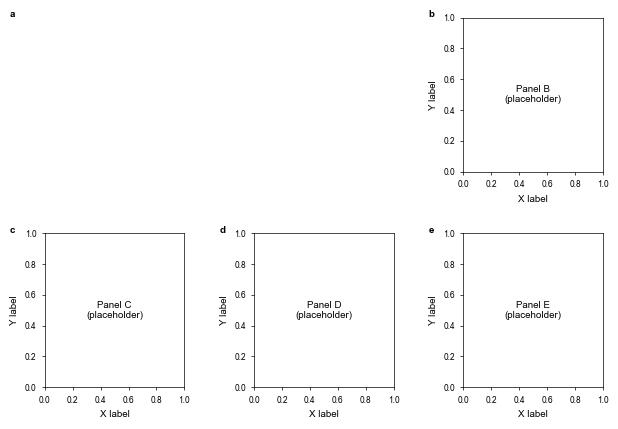

In [133]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Set matplotlib parameters for Nature Neuroscience specifications
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica']
plt.rcParams['font.size'] = 7
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['xtick.major.size'] = 2.5
plt.rcParams['ytick.major.size'] = 2.5

# =============================================================================
# CREATE FIGURE
# =============================================================================

print("="*80)
print("CREATING TASK PERFORMANCE FIGURE")
print("="*80)

# Create figure (Nature double column width: 180 mm = 7.09 inches)
fig = plt.figure(figsize=(7.2, 4.8))
main_gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.4, wspace=0.5)

# ROW 1: Panel A (merged ax_00 and ax_01), Panel B (ax_02)
ax_merged = fig.add_subplot(main_gs[0, 0:2])  # Merge first two columns
ax_02 = fig.add_subplot(main_gs[0, 2])

# ROW 2: Three panels (C, D, E)
ax_10 = fig.add_subplot(main_gs[1, 0])
ax_11 = fig.add_subplot(main_gs[1, 1])
ax_12 = fig.add_subplot(main_gs[1, 2])

# =============================================================================
# PANEL A: Task schematic (merged panel)
# =============================================================================

# ax_merged.text(
#     0.5, 0.95, 'HD input pattern 1', 
#     ha='center', va='center', fontsize=6, transform=ax_merged.transAxes,
#     bbox=dict(boxstyle='round', facecolor='red', alpha=0.7, edgecolor='black', pad=0.2)
# )
# ax_merged.text(
#     0.5, 0.8, 'HD input pattern 2', 
#     ha='center', va='center', fontsize=6, transform=ax_merged.transAxes,
#     bbox=dict(boxstyle='round', facecolor='blue', alpha=0.7, edgecolor='black', pad=0.2)
# )
# ax_merged.text(
#     0.5, 0.65, 'HD input pattern 3', 
#     ha='center', va='center', fontsize=6, transform=ax_merged.transAxes,
#     bbox=dict(boxstyle='round', facecolor='green', alpha=0.7, edgecolor='black', pad=0.2)
# )
# ax_merged.text(
#     0.5, 0.45, 'HD input pattern 4', 
#     ha='center', va='center', fontsize=6, transform=ax_merged.transAxes,
#     bbox=dict(boxstyle='round', facecolor='orange', alpha=0.7, edgecolor='black', pad=0.2)
# )

# ax_merged.text(
#     0.5, 0.15, 'Output\nlayer', 
#     ha='center', va='center', fontsize=7, transform=ax_merged.transAxes
# )

ax_merged.set_xlim(0, 1)
ax_merged.set_ylim(0, 1)
ax_merged.axis('off')

# Panel label
ax_merged.text(-0.1, 1.05, 'a', transform=ax_merged.transAxes, 
               fontsize=7, fontweight='bold', va='top')

# =============================================================================
# PANEL B: Placeholder
# =============================================================================

ax_02.text(0.5, 0.5, 'Panel B\n(placeholder)', 
           ha='center', va='center', fontsize=7, transform=ax_02.transAxes)
ax_02.set_xlim(0, 1)
ax_02.set_ylim(0, 1)
ax_02.set_xlabel('X label', fontsize=7)
ax_02.set_ylabel('Y label', fontsize=7)
ax_02.tick_params(labelsize=6)

# Panel label
ax_02.text(-0.25, 1.05, 'b', transform=ax_02.transAxes, 
           fontsize=7, fontweight='bold', va='top')

# =============================================================================
# PANEL C: Placeholder
# =============================================================================

ax_10.text(0.5, 0.5, 'Panel C\n(placeholder)', 
           ha='center', va='center', fontsize=7, transform=ax_10.transAxes)
ax_10.set_xlim(0, 1)
ax_10.set_ylim(0, 1)
ax_10.set_xlabel('X label', fontsize=7)
ax_10.set_ylabel('Y label', fontsize=7)
ax_10.tick_params(labelsize=6)

# Panel label
ax_10.text(-0.25, 1.05, 'c', transform=ax_10.transAxes, 
           fontsize=7, fontweight='bold', va='top')

# =============================================================================
# PANEL D: Placeholder
# =============================================================================

ax_11.text(0.5, 0.5, 'Panel D\n(placeholder)', 
           ha='center', va='center', fontsize=7, transform=ax_11.transAxes)
ax_11.set_xlim(0, 1)
ax_11.set_ylim(0, 1)
ax_11.set_xlabel('X label', fontsize=7)
ax_11.set_ylabel('Y label', fontsize=7)
ax_11.tick_params(labelsize=6)

# Panel label
ax_11.text(-0.25, 1.05, 'd', transform=ax_11.transAxes, 
           fontsize=7, fontweight='bold', va='top')

# =============================================================================
# PANEL E: Placeholder
# =============================================================================

ax_12.text(0.5, 0.5, 'Panel E\n(placeholder)', 
           ha='center', va='center', fontsize=7, transform=ax_12.transAxes)
ax_12.set_xlim(0, 1)
ax_12.set_ylim(0, 1)
ax_12.set_xlabel('X label', fontsize=7)
ax_12.set_ylabel('Y label', fontsize=7)
ax_12.tick_params(labelsize=6)

# Panel label
ax_12.text(-0.25, 1.05, 'e', transform=ax_12.transAxes, 
           fontsize=7, fontweight='bold', va='top')

# =============================================================================
# SAVE FIGURE
# =============================================================================

plt.savefig('nature_task_performance_figure.svg', format='svg', dpi=450, bbox_inches='tight')
plt.savefig('nature_task_performance_figure.pdf', format='pdf', dpi=450, bbox_inches='tight')

print("\nFigure saved as 'nature_task_performance_figure.svg' and '.pdf'")
print("\nLayout:")
print("  Row 1: Panel A (merged 2 columns), Panel B")
print("  Row 2: Panel C, Panel D, Panel E")
print("\nAll fontsizes comply with Nature Neuroscience guidelines (5-7 pt):")
print("  - Panel labels (a,b,c,d,e): 7 pt bold")
print("  - Axis labels: 7 pt")
print("  - Tick labels: 6 pt")

plt.show()

AUTO-ENCODING WITH PROPER TRANSIENT
Pattern: (3000, 4), d=4, k=4

Network: 1000 neurons, g=1.0, v_th=0.0
Static: 30.0 Hz (common_tonic)
Strategy: Run 500.0ms transient ONCE, then 100 trials

INITIALIZING NETWORK
✓ Network initialized

RUNNING TRANSIENT (500.0ms) - ONCE ONLY
Running 5000 steps...
✓ Transient complete
  Total spikes: 9134
  Network time: 500.0 ms
✓ Saved steady state
  Membrane potentials: mean=-59.61 mV, std=6.03 mV

RUNNING 100 TRIALS FROM STEADY STATE

  Trial 0 DEBUG:
    Total spikes: 16650
    First spike at: 0.00 ms (relative to stimulus start)
    Last spike at: 299.90 ms
    Spikes in first 20ms: 1315
    First 10: [0.0, 0.0, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.30000000000000004]
  Completed trial 20/100
  Completed trial 40/100
  Completed trial 60/100
  Completed trial 80/100
  Completed trial 100/100

✓ Collected 100 trials
  Mean spikes/trial: 16794.4

PREPARING DATA
✓ X: (100, 3000, 1000), y: (100, 3000, 4)

20-FOLD CV
  Fold 5/20: R²=0.959, RMSE=0.203
  F

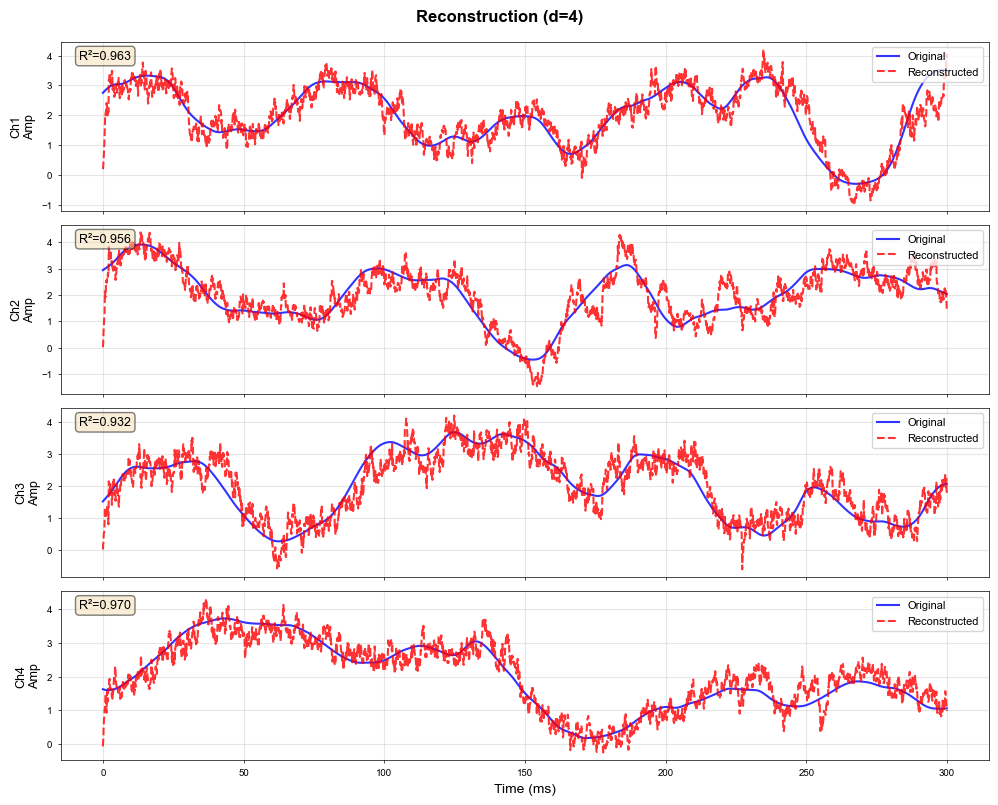

✓ Saved: autoencoding_proper_transient.png

COMPLETE!


In [3]:
"""
Auto-encoding experiment - PROPER TRANSIENT HANDLING
=====================================================

CORRECT APPROACH:
1. Run 500ms transient ONCE to reach steady state
2. Save network state
3. For each trial: restore state, then run stimulus

This ensures spikes appear immediately when HD input arrives!
"""

#%% IMPORTS
import numpy as np
import matplotlib.pyplot as plt
from src.spiking_network import SpikingRNN
from analysis.common_utils import apply_exponential_filter, spikes_to_matrix
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error

print("="*80)
print("AUTO-ENCODING WITH PROPER TRANSIENT")
print("="*80)
print(f"Pattern: {pattern_d2.shape}, d={d2}, k={k}")

#%% PARAMETERS
n_neurons = 1000
g_std = 1.0
v_th_std = 0.0
static_input_rate = 30.0

transient_time = 500.0  # Run ONCE
n_trials = 100

tau_syn = 5.0
lambda_reg = 0.001
n_folds = 20

print(f"\nNetwork: {n_neurons} neurons, g={g_std}, v_th={v_th_std}")
print(f"Static: {static_input_rate} Hz (common_tonic)")
print(f"Strategy: Run {transient_time}ms transient ONCE, then {n_trials} trials")

#%% INITIALIZE NETWORK
print("\n" + "="*80)
print("INITIALIZING NETWORK")
print("="*80)

network = SpikingRNN(
    n_neurons=n_neurons,
    dt=dt,
    synaptic_mode="filter",
    static_input_mode="common_tonic",
    hd_input_mode="common_tonic",
    n_hd_channels=k,
    use_readout_synapses=False
)

network.initialize_network(
    session_id=session_id,
    v_th_std=v_th_std,
    g_std=g_std,
    v_th_distribution='normal',
    hd_dim=d2,
    embed_dim=k,
    static_input_strength=10.0,      
    hd_connection_prob=0.3,           
    hd_input_strength=50.0 
)

print("✓ Network initialized")

#%% RUN TRANSIENT PERIOD ONCE
print("\n" + "="*80)
print(f"RUNNING TRANSIENT ({transient_time}ms) - ONCE ONLY")
print("="*80)

# Reset for transient
network.reset_simulation(session_id, v_th_std, g_std, trial_id=0)

transient_steps = int(transient_time / dt)
transient_spikes = 0

print(f"Running {transient_steps} steps...")

for step in range(transient_steps):
    spike_indices, _ = network.step(
        session_id=session_id,
        v_th_std=v_th_std,
        g_std=g_std,
        trial_id=0,
        static_input_rate=static_input_rate,
        time_step=step
    )
    transient_spikes += len(spike_indices)
    
    if step == 0 and len(spike_indices) > 0:
        first_spike_time = network.current_time - dt
        print(f"  First spike at: {first_spike_time:.2f} ms")

print(f"✓ Transient complete")
print(f"  Total spikes: {transient_spikes}")
print(f"  Network time: {network.current_time:.1f} ms")

# Save steady-state
steady_state_v = network.neurons.v_membrane.copy()
steady_state_refrac = network.neurons.refractory_timer.copy()
steady_state_time = network.neurons.last_spike_time.copy()

print(f"✓ Saved steady state")
print(f"  Membrane potentials: mean={np.mean(steady_state_v):.2f} mV, std={np.std(steady_state_v):.2f} mV")

#%% RUN TRIALS FROM STEADY STATE
print("\n" + "="*80)
print(f"RUNNING {n_trials} TRIALS FROM STEADY STATE")
print("="*80)

spike_data_all = []
n_timesteps = pattern_d2.shape[0]
stimulus_steps = n_timesteps

for trial in range(n_trials):
    
    # RESTORE steady state (don't reset!)
    network.neurons.v_membrane = steady_state_v.copy()
    network.neurons.refractory_timer = steady_state_refrac.copy()
    network.neurons.last_spike_time = steady_state_time.copy()
    network.current_time = transient_time  # Continue from where we left off
    network.spike_times = []
    
    # Run stimulus with HD input
    trial_spikes = []
    
    for step in range(stimulus_steps):
        hd_rates = pattern_d2[step] if step < len(pattern_d2) else np.zeros(k)
        
        spike_indices, _ = network.step(
            session_id=session_id,
            v_th_std=v_th_std,
            g_std=g_std,
            trial_id=trial,
            static_input_rate=static_input_rate,
            hd_input_rates=hd_rates,
            hd_dim=d2,
            embed_dim=k,
            time_step=transient_steps + step
        )
        
        # Record spikes relative to stimulus start (not absolute time)
        for neuron_id in spike_indices:
            trial_spikes.append((step * dt, neuron_id))
    
    spike_data_all.append(trial_spikes)
    
    # Debug first trial
    if trial == 0:
        print(f"\n  Trial 0 DEBUG:")
        print(f"    Total spikes: {len(trial_spikes)}")
        if len(trial_spikes) > 0:
            print(f"    First spike at: {trial_spikes[0][0]:.2f} ms (relative to stimulus start)")
            print(f"    Last spike at: {trial_spikes[-1][0]:.2f} ms")
            
            # Check first 20ms
            early_spikes = [s[0] for s in trial_spikes if s[0] < 20]
            print(f"    Spikes in first 20ms: {len(early_spikes)}")
            if len(early_spikes) > 0:
                print(f"    First 10: {sorted(early_spikes)[:10]}")
        else:
            print(f"    ⚠️ NO SPIKES!")
    
    if (trial + 1) % 20 == 0:
        print(f"  Completed trial {trial + 1}/{n_trials}")

print(f"\n✓ Collected {len(spike_data_all)} trials")
print(f"  Mean spikes/trial: {np.mean([len(s) for s in spike_data_all]):.1f}")

#%% PREPARE DATA
print("\n" + "="*80)
print("PREPARING DATA")
print("="*80)

X_all = []

for trial_idx in range(n_trials):
    spike_matrix = spikes_to_matrix(
        spike_data_all[trial_idx],
        n_timesteps,
        n_neurons,
        dt
    )
    
    filtered = apply_exponential_filter(spike_matrix, tau_syn, dt)
    X_all.append(filtered)

X_all = np.array(X_all)
y_all = np.tile(pattern_d2[np.newaxis, :, :], (n_trials, 1, 1))

print(f"✓ X: {X_all.shape}, y: {y_all.shape}")

#%% K-FOLD CV
print("\n" + "="*80)
print(f"{n_folds}-FOLD CV")
print("="*80)

X_flat = X_all.reshape(-1, n_neurons)
y_flat = y_all.reshape(-1, k)

kf = KFold(n_splits=n_folds, shuffle=True, random_state=session_id)

y_pred_all = np.zeros_like(y_flat)
fold_r2_scores = []
fold_rmse_scores = []

for fold_idx, (train_trials, test_trials) in enumerate(kf.split(np.arange(n_trials))):
    
    train_indices = []
    test_indices = []
    
    for trial in train_trials:
        train_indices.extend(range(trial * n_timesteps, (trial + 1) * n_timesteps))
    for trial in test_trials:
        test_indices.extend(range(trial * n_timesteps, (trial + 1) * n_timesteps))
    
    train_indices = np.array(train_indices)
    test_indices = np.array(test_indices)
    
    X_train = X_flat[train_indices]
    y_train = y_flat[train_indices]
    X_test = X_flat[test_indices]
    y_test = y_flat[test_indices]
    
    decoder = Ridge(alpha=lambda_reg, fit_intercept=False)
    decoder.fit(X_train, y_train)
    
    y_pred = decoder.predict(X_test)
    y_pred_all[test_indices] = y_pred
    
    fold_r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
    fold_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    fold_r2_scores.append(fold_r2)
    fold_rmse_scores.append(fold_rmse)
    
    if (fold_idx + 1) % 5 == 0:
        print(f"  Fold {fold_idx + 1}/{n_folds}: R²={fold_r2:.3f}, RMSE={fold_rmse:.3f}")

print(f"\n✓ CV complete")

# Per-channel metrics
r2_per_channel = []
rmse_per_channel = []
corr_per_channel = []

for ch in range(k):
    r2_ch = r2_score(y_flat[:, ch], y_pred_all[:, ch])
    rmse_ch = np.sqrt(mean_squared_error(y_flat[:, ch], y_pred_all[:, ch]))
    corr_ch = np.corrcoef(y_flat[:, ch], y_pred_all[:, ch])[0, 1]
    
    r2_per_channel.append(r2_ch)
    rmse_per_channel.append(rmse_ch)
    corr_per_channel.append(corr_ch)

r2_per_channel = np.array(r2_per_channel)
rmse_per_channel = np.array(rmse_per_channel)
corr_per_channel = np.array(corr_per_channel)

#%% FINAL DECODER
print("\n" + "="*80)
print("FINAL DECODER")
print("="*80)

final_decoder = Ridge(alpha=lambda_reg, fit_intercept=False)
final_decoder.fit(X_flat, y_flat)
y_pred_final = final_decoder.predict(X_flat)

print("✓ Trained on all data")

#%% RESULTS
print("\n" + "="*80)
print("RESULTS")
print("="*80)

print(f"\nPerformance (d={d2}):")
print(f"  R²:   {np.mean(r2_per_channel):.3f} ± {np.std(r2_per_channel):.3f}")
print(f"  RMSE: {np.mean(rmse_per_channel):.3f} ± {np.std(rmse_per_channel):.3f}")
print(f"  Corr: {np.mean(corr_per_channel):.3f} ± {np.std(corr_per_channel):.3f}")

print(f"\nPer-channel:")
for ch in range(k):
    print(f"  Ch{ch+1}: R²={r2_per_channel[ch]:.3f}, RMSE={rmse_per_channel[ch]:.3f}, r={corr_per_channel[ch]:.3f}")

#%% PLOTS
print("\n" + "="*80)
print("PLOTTING")
print("="*80)

y_pred_reshaped = y_pred_final.reshape(n_trials, n_timesteps, k)
time_array = np.arange(n_timesteps) * dt

# Channel signals
fig, axes = plt.subplots(k, 1, figsize=(10, 2*k), sharex=True)
if k == 1:
    axes = [axes]

for ch in range(k):
    ax = axes[ch]
    ax.plot(time_array, pattern_d2[:, ch], 'b-', linewidth=1.5, 
            label='Original', alpha=0.8)
    ax.plot(time_array, y_pred_reshaped[0, :, ch], 'r--', linewidth=1.5, 
            label='Reconstructed', alpha=0.8)
    ax.set_ylabel(f'Ch{ch+1}\nAmp', fontsize=9)
    ax.grid(alpha=0.3)
    ax.legend(loc='upper right', fontsize=8)
    ax.text(0.02, 0.95, f'R²={r2_per_channel[ch]:.3f}', 
            transform=ax.transAxes, fontsize=9, va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[-1].set_xlabel('Time (ms)', fontsize=10)
fig.suptitle(f'Reconstruction (d={d2})', fontsize=12, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('autoencoding_proper_transient.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: autoencoding_proper_transient.png")

print("\n" + "="*80)
print("COMPLETE!")
print("="*80)

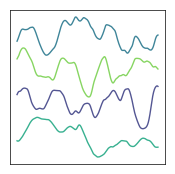

In [13]:
fig, ax = plt.subplots(figsize=(2, 2))
for i in range(k-1):
    ax.plot(3*(i+1) + pattern_d2[:, i], linewidth=1, 
                     color=channel_colors[i], alpha=0.9)
ax.plot(pattern_d2[:, k-1], linewidth=1, 
                     color=channel_colors[k-1], alpha=0.9)

ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

plt.savefig('hd_input.svg', format='svg', dpi=450, bbox_inches='tight')

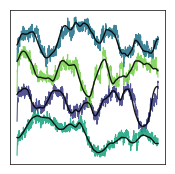

In [44]:
fig, ax = plt.subplots(figsize=(2, 2))
for i in range(k-1):
    ax.plot(3*(i+1) + y_pred_reshaped[0, :, i], linewidth=0.8, 
                     color=channel_colors[i], alpha=0.9)
ax.plot(y_pred_reshaped[0, :, k-1], linewidth=0.8, 
                     color=channel_colors[k-1], alpha=0.9)

for i in range(k-1):
    ax.plot(3*(i+1) + pattern_d2[:, i], linewidth=1, 
                     color="k", alpha=0.9)
ax.plot(pattern_d2[:, k-1], linewidth=1, 
                     color="k", alpha=0.9)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.savefig('recunstructed_hd_input.svg', format='svg', dpi=450, bbox_inches='tight')

✓ Imports successful!
✓ Parameters configured!
✓ Experiment initialized: 4 patterns × 100 trials = 400 total

📊 Generating HD input patterns...
✓ Generated 4 patterns

🧠 Simulating 400 trials...
   Rank 0: completed 20/400 trials
   Rank 0: completed 40/400 trials
   Rank 0: completed 60/400 trials
   Rank 0: completed 80/400 trials
   Rank 0: completed 100/400 trials
   Rank 0: completed 120/400 trials
   Rank 0: completed 140/400 trials
   Rank 0: completed 160/400 trials
   Rank 0: completed 180/400 trials
   Rank 0: completed 200/400 trials
   Rank 0: completed 220/400 trials
   Rank 0: completed 240/400 trials
   Rank 0: completed 260/400 trials
   Rank 0: completed 280/400 trials
   Rank 0: completed 300/400 trials
   Rank 0: completed 320/400 trials
   Rank 0: completed 340/400 trials
   Rank 0: completed 360/400 trials
   Rank 0: completed 380/400 trials
   Rank 0: completed 400/400 trials
✓ Simulation complete! Mean spikes: 22797.0 ± 968.3

🔄 Converting spikes to traces...
✓ T

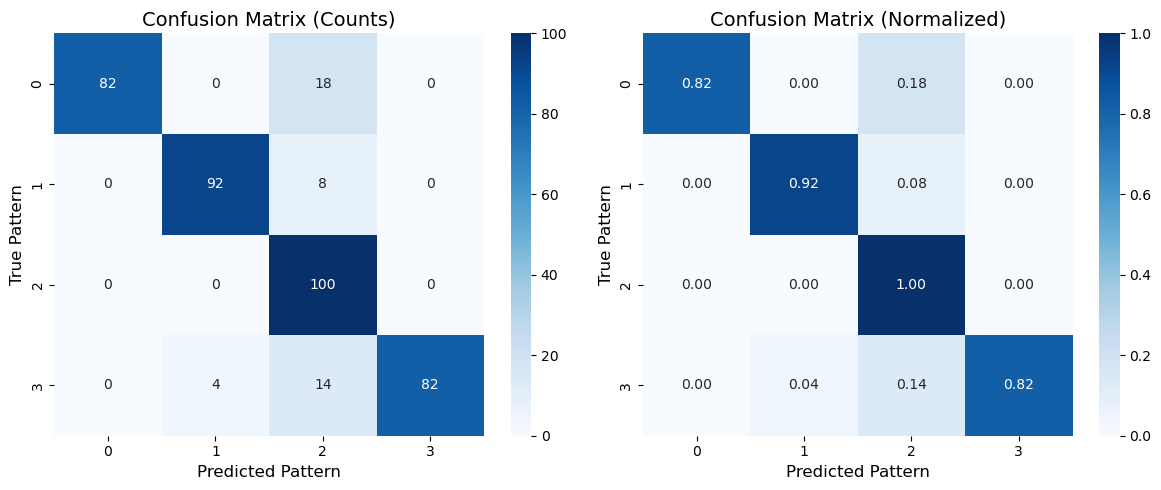

Example trials: [0, 100, 200, 300]


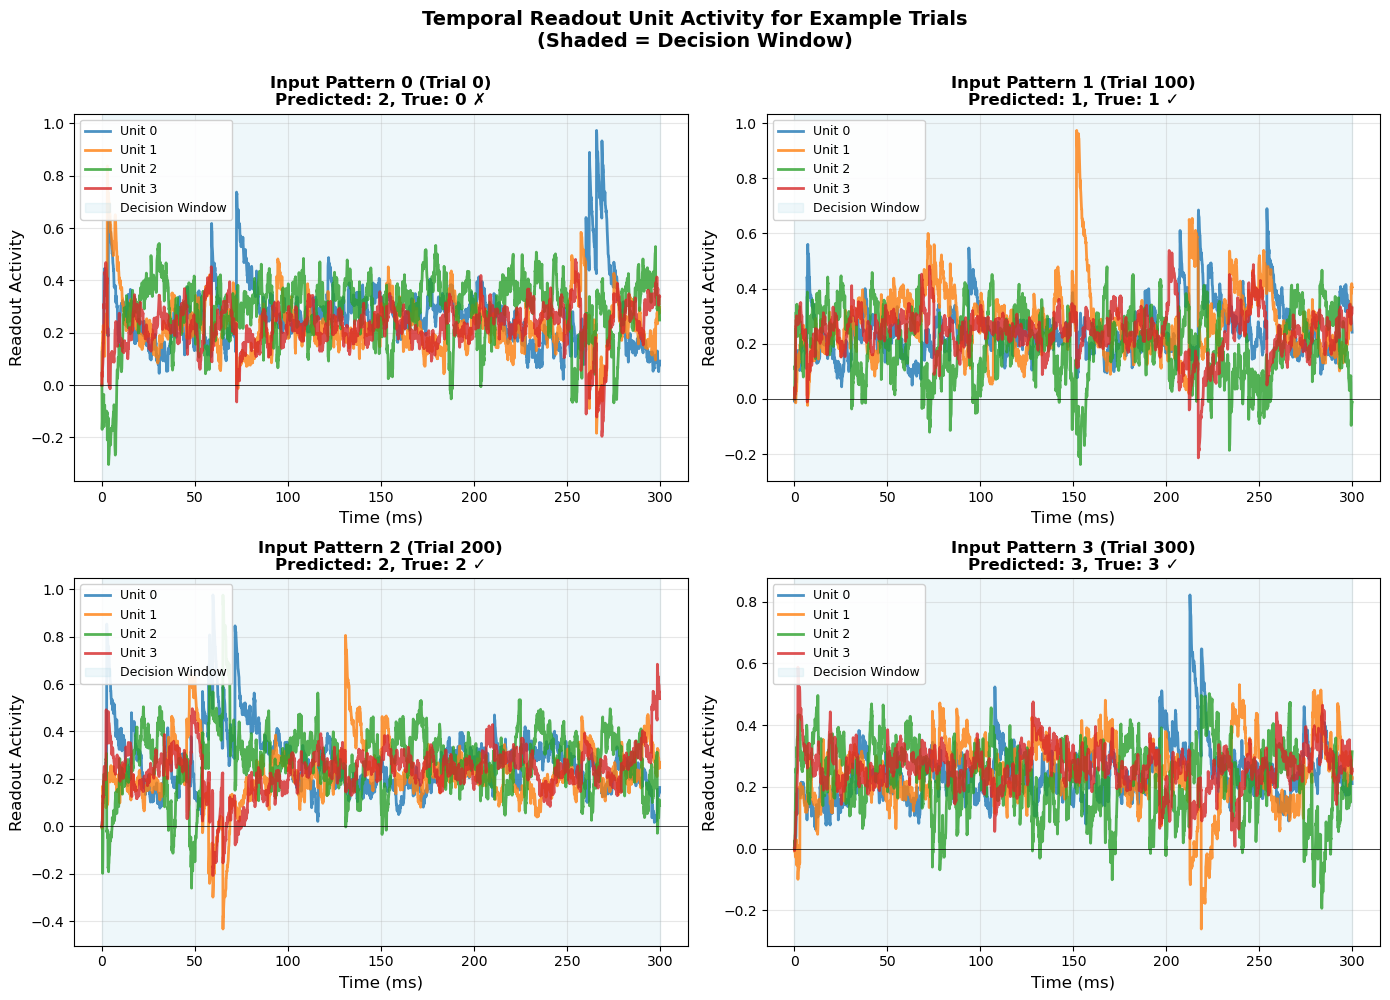

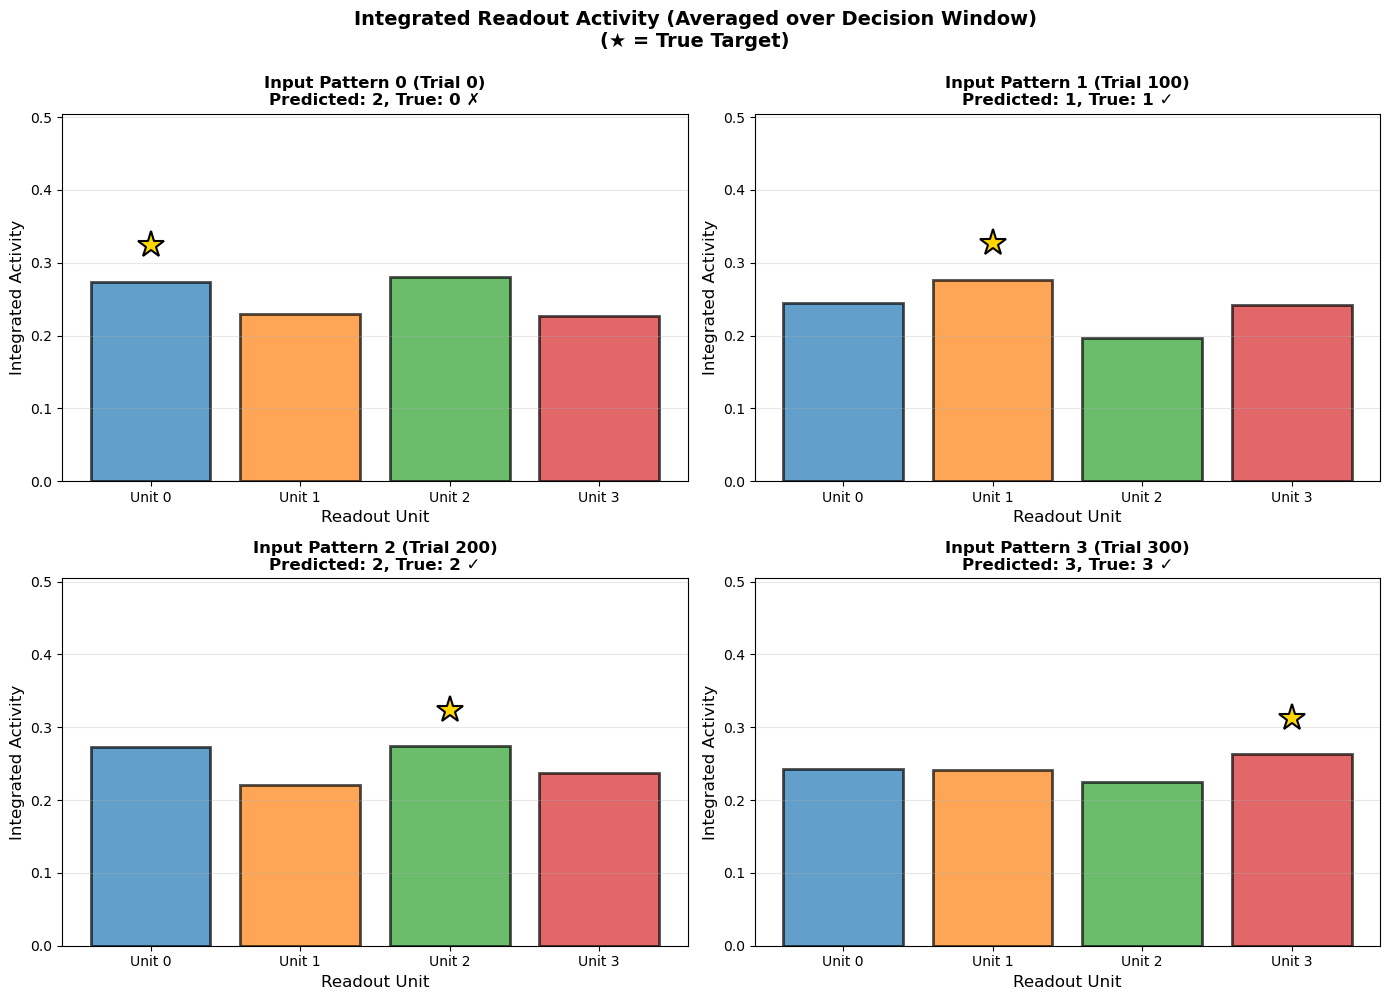

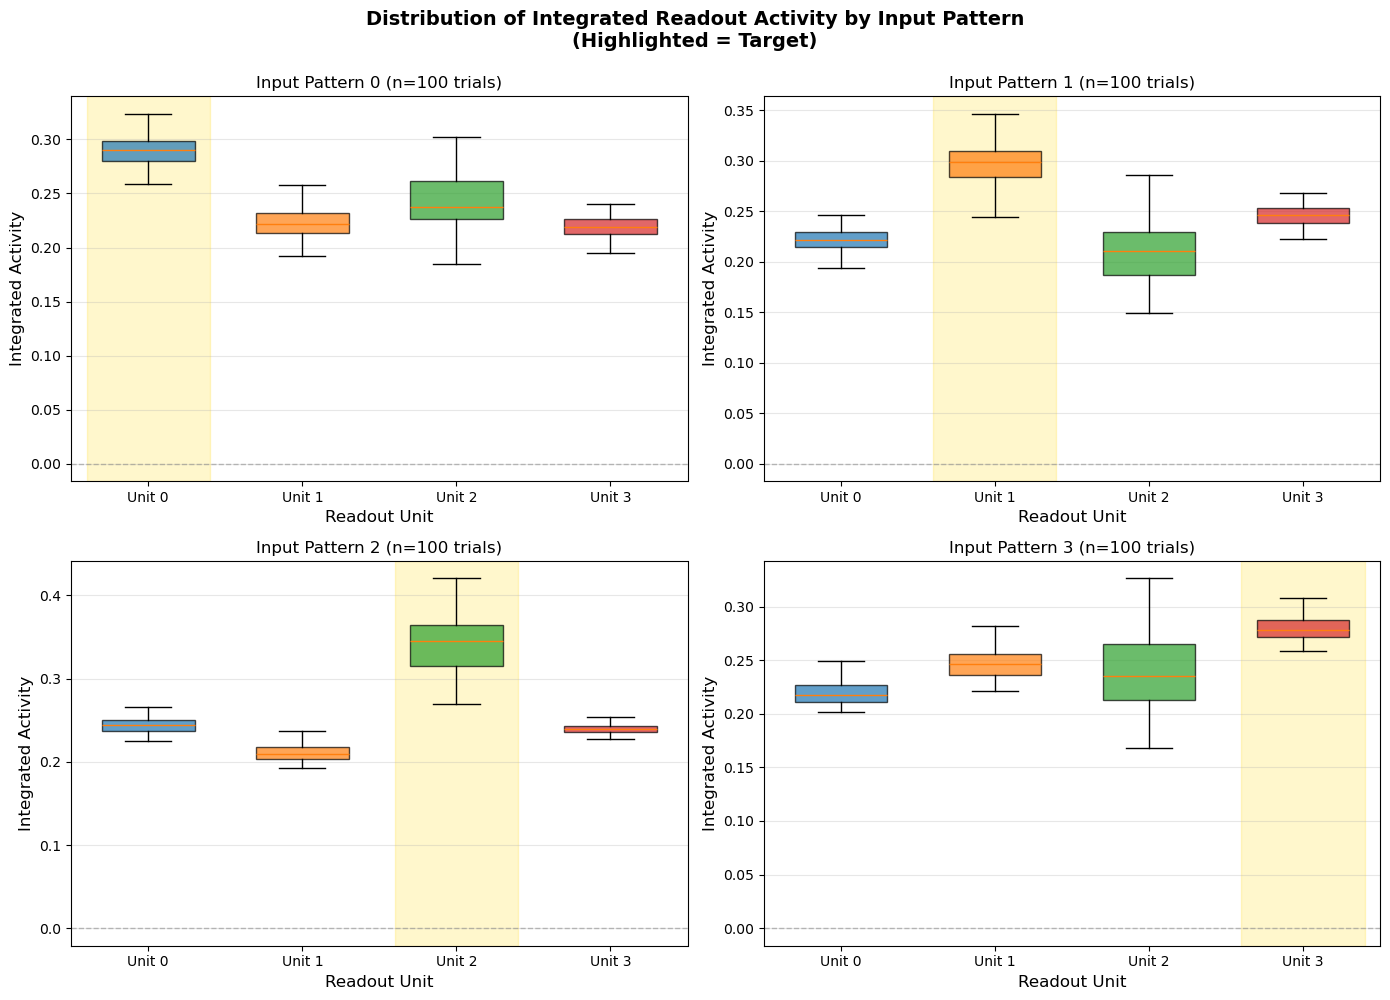

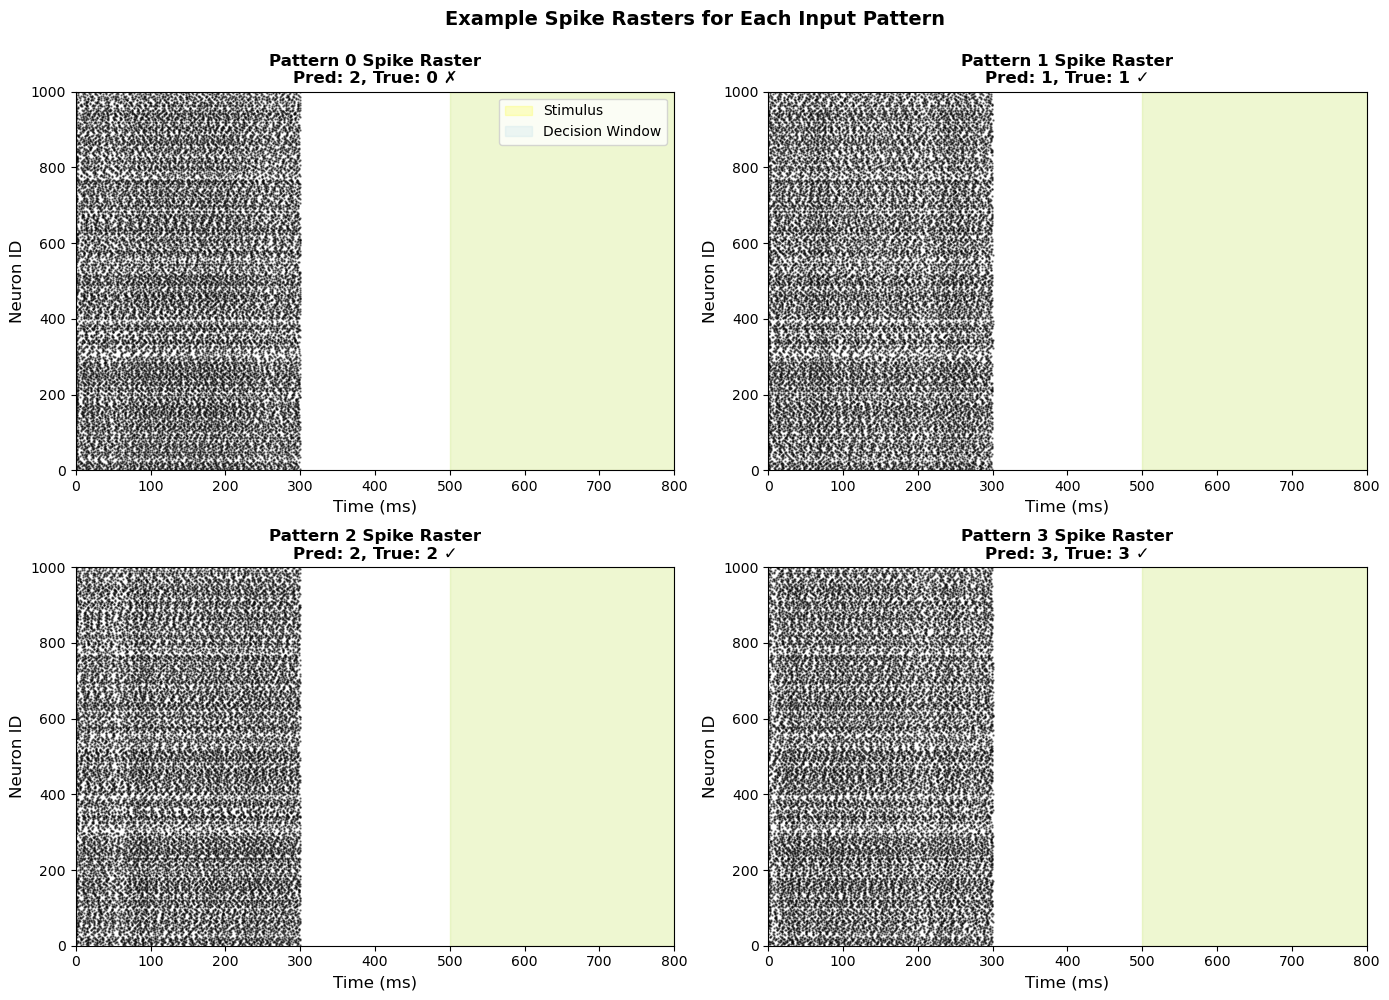


CATEGORICAL CLASSIFICATION SUMMARY
Network: 1000 neurons, σ_vth=0.0, σ_g=1.0
Task: 4 patterns × 100 trials

CV Test Accuracy (20 folds): 0.870 ± 0.094
First Fold Accuracy: 0.890
Chance Level: 0.250

Decision method: Average readout activity over 300.0ms window

Per-Pattern Accuracy:
  Pattern 0: 0.820
  Pattern 1: 0.920
  Pattern 2: 1.000
  Pattern 3: 0.820

✅ All visualizations complete!


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from typing import Dict, List, Tuple
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Import your modules
from experiments.task_performance_experiment import TaskPerformanceExperiment
from experiments.experiment_utils import predict_task_readout

print("✓ Imports successful!")

# ============================================================================
# PARAMETERS
# ============================================================================
session_id = 0
n_input_patterns = 4
n_neurons = 1000
n_trials = 100
input_hd_dim = 1
embed_dim_input = 4
output_hd_dim = n_input_patterns
synaptic_mode = "filter"
static_input_mode = "common_tonic"
hd_input_mode = "common_tonic"
v_th_distribution = "normal"
v_th_std = 0.0
g_std = 1.0
static_input_rate = 30.0
static_input_strength = 10.0
hd_connection_prob = 0.3
hd_input_strength = 50.0
dt = 0.1
tau_syn = 5.0
transient_time = 500.0
stimulus_duration = 300.0
decision_window = 300.0
lambda_reg = 0.001
n_folds = 20
signal_cache_dir = "/tmp/hd_signals"
os.makedirs(signal_cache_dir, exist_ok=True)

print("✓ Parameters configured!")

# ============================================================================
# INITIALIZE EXPERIMENT
# ============================================================================
experiment = TaskPerformanceExperiment(
    task_type='categorical',
    n_neurons=n_neurons,
    n_input_patterns=n_input_patterns,
    input_dim_intrinsic=input_hd_dim,
    input_dim_embedding=embed_dim_input,
    output_dim_intrinsic=output_hd_dim,
    output_dim_embedding=0,
    dt=dt,
    tau_syn=tau_syn,
    synaptic_mode=synaptic_mode,
    static_input_mode=static_input_mode,
    hd_input_mode=hd_input_mode,
    signal_cache_dir=signal_cache_dir,
    decision_window=decision_window,
    stimulus_duration=stimulus_duration,
    n_trials_per_pattern=n_trials,
    lambda_reg=lambda_reg,
    use_distributed_cv=False
)

print(f"✓ Experiment initialized: {n_input_patterns} patterns × {n_trials} trials = {n_input_patterns * n_trials} total")

# ============================================================================
# GENERATE PATTERNS
# ============================================================================
print("\n📊 Generating HD input patterns...")
input_patterns = experiment.input_generator.initialize_and_get_patterns(
    session_id=session_id,
    hd_dim=input_hd_dim,
    n_patterns=n_input_patterns
)
output_patterns = experiment.generate_output_patterns(session_id)
print(f"✓ Generated {len(input_patterns)} patterns")

# ============================================================================
# SIMULATE TRIALS
# ============================================================================
print(f"\n🧠 Simulating {n_input_patterns * n_trials} trials...")
all_trial_indices = list(range(n_input_patterns * n_trials))
spike_times_all = experiment.simulate_trials_parallel(
    session_id=session_id,
    v_th_std=v_th_std,
    g_std=g_std,
    v_th_distribution=v_th_distribution,
    static_input_rate=static_input_rate,
    my_trial_indices=all_trial_indices,
    input_patterns=input_patterns,
    rank=0
)
spike_counts = [len(trial['spike_times']) for trial in spike_times_all]
print(f"✓ Simulation complete! Mean spikes: {np.mean(spike_counts):.1f} ± {np.std(spike_counts):.1f}")

# ============================================================================
# CONVERT TO TRACES
# ============================================================================
print("\n🔄 Converting spikes to traces...")
traces_all, ground_truth_all, pattern_ids = experiment.convert_spikes_to_traces(
    spike_times_all, output_patterns, n_input_patterns, n_trials
)
print(f"✓ Traces shape: {traces_all.shape}")
print(f"✓ Ground truth shape: {ground_truth_all.shape}")

# ============================================================================
# CROSS-VALIDATION
# ============================================================================
print(f"\n🎯 Training decoder with {n_folds}-fold CV...")
cv_results = experiment.cross_validate(
    traces_all=traces_all,
    ground_truth_all=ground_truth_all,
    pattern_ids=pattern_ids,
    session_id=session_id,
    n_folds=n_folds,
    rank=0,
    size=1,
    comm=None
)
print(f"\n✓ Test Accuracy: {cv_results['test_accuracy_mean']:.3f} ± {cv_results['test_accuracy_std']:.3f}")
print(f"✓ Train Accuracy: {cv_results['train_accuracy_mean']:.3f} ± {cv_results['train_accuracy_std']:.3f}")

# ============================================================================
# GET PREDICTIONS FROM FIRST CV FOLD
# ============================================================================
print("\n🔧 Using first CV fold for visualization...")

# Get the trained weights from the first fold
W_readout = cv_results['readout_weights'][0]
print(f"✓ Readout weights shape: {W_readout.shape}")

# Predict temporal signals for ALL trials using first fold's weights
predictions_temporal = predict_task_readout(traces_all, W_readout)
print(f"✓ Temporal predictions shape: {predictions_temporal.shape}")

# Integrate over decision window to get class predictions
decision_window_steps = int(decision_window / dt)
predictions_decision = predictions_temporal[:, -decision_window_steps:, :]
predictions_integrated = np.mean(predictions_decision, axis=1)  # (n_trials, n_classes)
predicted_classes = np.argmax(predictions_integrated, axis=1)
true_classes = np.argmax(ground_truth_all[:, 0, :], axis=1)

overall_accuracy = np.mean(predicted_classes == true_classes)
print(f"✓ Overall accuracy (first fold): {overall_accuracy:.3f}")

# ============================================================================
# VISUALIZATION 1: CONFUSION MATRIX
# ============================================================================
print("\n📊 Creating visualizations...")

cm = confusion_matrix(true_classes, predicted_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, 
            xticklabels=range(n_input_patterns), yticklabels=range(n_input_patterns))
ax1.set_xlabel('Predicted Pattern', fontsize=12)
ax1.set_ylabel('True Pattern', fontsize=12)
ax1.set_title('Confusion Matrix (Counts)', fontsize=14)

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax2,
            xticklabels=range(n_input_patterns), yticklabels=range(n_input_patterns))
ax2.set_xlabel('Predicted Pattern', fontsize=12)
ax2.set_ylabel('True Pattern', fontsize=12)
ax2.set_title('Confusion Matrix (Normalized)', fontsize=14)
plt.tight_layout()
plt.show()

# ============================================================================
# VISUALIZATION 2: TEMPORAL READOUT SIGNALS (KEY PLOT!)
# ============================================================================
# Select one example trial from each pattern
example_trials = []
for pattern_id in range(n_input_patterns):
    pattern_mask = pattern_ids == pattern_id
    pattern_indices = np.where(pattern_mask)[0]
    example_trials.append(pattern_indices[0])

print(f"Example trials: {example_trials}")

# Create time axis
time_axis = np.arange(predictions_temporal.shape[1]) * dt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, (trial_idx, pattern_id) in enumerate(zip(example_trials, range(n_input_patterns))):
    ax = axes[idx]
    
    # Plot temporal activity for each readout unit
    for readout_unit in range(n_input_patterns):
        temporal_activity = predictions_temporal[trial_idx, :, readout_unit]
        ax.plot(time_axis, temporal_activity, color=colors[readout_unit], 
                linewidth=2, label=f'Unit {readout_unit}', alpha=0.8)
    
    # Mark decision window
    decision_start = time_axis[-decision_window_steps]
    ax.axvspan(decision_start, time_axis[-1], alpha=0.2, color='lightblue', 
               label='Decision Window')
    
    pred_class = predicted_classes[trial_idx]
    true_class = true_classes[trial_idx]
    correct = "✓" if pred_class == true_class else "✗"
    
    ax.set_xlabel('Time (ms)', fontsize=12)
    ax.set_ylabel('Readout Activity', fontsize=12)
    ax.set_title(f'Input Pattern {pattern_id} (Trial {trial_idx})\nPredicted: {pred_class}, True: {true_class} {correct}', 
                fontsize=12, fontweight='bold')
    ax.legend(loc='upper left', fontsize=9, framealpha=0.9)
    ax.grid(alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.suptitle('Temporal Readout Unit Activity for Example Trials\n(Shaded = Decision Window)', 
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ============================================================================
# VISUALIZATION 3: INTEGRATED READOUT ACTIVITY (BAR PLOT)
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (trial_idx, pattern_id) in enumerate(zip(example_trials, range(n_input_patterns))):
    ax = axes[idx]
    
    # Get integrated activity for this trial
    integrated_activity = predictions_integrated[trial_idx]
    true_label = ground_truth_all[trial_idx, 0, :]
    
    # Bar plot
    for readout_unit in range(n_input_patterns):
        activity = integrated_activity[readout_unit]
        ax.bar(readout_unit, activity, color=colors[readout_unit], 
               alpha=0.7, edgecolor='black', linewidth=2)
        
        # Mark the true target with a star
        if true_label[readout_unit] == 1.0:
            ax.plot(readout_unit, activity + 0.05, '*', markersize=20, 
                   color='gold', markeredgecolor='black', markeredgewidth=1.5)
    
    pred_class = predicted_classes[trial_idx]
    true_class = true_classes[trial_idx]
    correct = "✓" if pred_class == true_class else "✗"
    
    ax.set_xlabel('Readout Unit', fontsize=12)
    ax.set_ylabel('Integrated Activity', fontsize=12)
    ax.set_title(f'Input Pattern {pattern_id} (Trial {trial_idx})\nPredicted: {pred_class}, True: {true_class} {correct}', 
                fontsize=12, fontweight='bold')
    ax.set_xticks(range(n_input_patterns))
    ax.set_xticklabels([f'Unit {i}' for i in range(n_input_patterns)])
    ax.set_ylim([min(0, np.min(predictions_integrated) * 1.1), 
                 np.max(predictions_integrated) * 1.2])
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Integrated Readout Activity (Averaged over Decision Window)\n(★ = True Target)', 
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ============================================================================
# VISUALIZATION 4: DISTRIBUTION BY PATTERN
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for pattern_id in range(n_input_patterns):
    ax = axes[pattern_id]
    pattern_mask = pattern_ids == pattern_id
    pattern_predictions = predictions_integrated[pattern_mask]
    
    positions = range(n_input_patterns)
    data_to_plot = [pattern_predictions[:, i] for i in range(n_input_patterns)]
    
    bp = ax.boxplot(data_to_plot, positions=positions, patch_artist=True, widths=0.6, showfliers=False)
    
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Highlight the correct readout unit
    ax.axvspan(pattern_id - 0.4, pattern_id + 0.4, alpha=0.2, color='gold')
    
    ax.set_xlabel('Readout Unit', fontsize=12)
    ax.set_ylabel('Integrated Activity', fontsize=12)
    ax.set_title(f'Input Pattern {pattern_id} (n={np.sum(pattern_mask)} trials)', fontsize=12)
    ax.set_xticks(range(n_input_patterns))
    ax.set_xticklabels([f'Unit {i}' for i in range(n_input_patterns)])
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Distribution of Integrated Readout Activity by Input Pattern\n(Highlighted = Target)', 
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ============================================================================
# VISUALIZATION 5: SPIKE RASTERS
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (trial_idx, pattern_id) in enumerate(zip(example_trials, range(n_input_patterns))):
    ax = axes[idx]
    spikes = spike_times_all[trial_idx]['spike_times']
    
    if len(spikes) > 0:
        spike_times = [s[0] for s in spikes]
        neuron_ids = [s[1] for s in spikes]
        ax.scatter(spike_times, neuron_ids, s=0.5, c='black', alpha=0.5)
    
    # Mark stimulus period
    ax.axvspan(transient_time, transient_time + stimulus_duration, 
              alpha=0.2, color='yellow', label='Stimulus')
    
    # Mark decision window
    ax.axvspan(transient_time + stimulus_duration - decision_window, 
              transient_time + stimulus_duration,
              alpha=0.2, color='lightblue', label='Decision Window')
    
    pred_class = predicted_classes[trial_idx]
    true_class = true_classes[trial_idx]
    correct = "✓" if pred_class == true_class else "✗"
    
    ax.set_xlabel('Time (ms)', fontsize=12)
    ax.set_ylabel('Neuron ID', fontsize=12)
    ax.set_title(f'Pattern {pattern_id} Spike Raster\nPred: {pred_class}, True: {true_class} {correct}', 
                fontsize=12, fontweight='bold')
    ax.set_xlim([0, transient_time + stimulus_duration])
    ax.set_ylim([0, n_neurons])
    if idx == 0:
        ax.legend(loc='upper right', fontsize=10)

plt.suptitle('Example Spike Rasters for Each Input Pattern', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*70)
print("CATEGORICAL CLASSIFICATION SUMMARY")
print("="*70)
print(f"Network: {n_neurons} neurons, σ_vth={v_th_std}, σ_g={g_std}")
print(f"Task: {n_input_patterns} patterns × {n_trials} trials")
print(f"\nCV Test Accuracy (20 folds): {cv_results['test_accuracy_mean']:.3f} ± {cv_results['test_accuracy_std']:.3f}")
print(f"First Fold Accuracy: {overall_accuracy:.3f}")
print(f"Chance Level: {1.0/n_input_patterns:.3f}")
print(f"\nDecision method: Average readout activity over {decision_window}ms window")
print("\nPer-Pattern Accuracy:")
for pattern_id in range(n_input_patterns):
    mask = pattern_ids == pattern_id
    pattern_acc = np.mean(predicted_classes[mask] == true_classes[mask])
    print(f"  Pattern {pattern_id}: {pattern_acc:.3f}")
print("="*70)
print("\n✅ All visualizations complete!")

In [62]:
import pickle

# Prepare data to save
data_to_save = {
    'trial_idx': trial_idx,
    'true_class': true_classes[trial_idx],
    'predicted_class': predicted_classes[trial_idx],
    'time_axis': time_axis,
    'accumulated_probability': running_avg_probs,  # (time, n_classes)
    'instantaneous_probability': predictions_probs,  # (time, n_classes)
    'temporal_predictions': predictions_temporal[trial_idx],  # (time, n_classes)
    'parameters': {
        'dt': dt,
        'n_classes': n_input_patterns,
        'stimulus_duration': stimulus_duration,
        'decision_window': decision_window
    }
}

# Save to pickle file
output_file = f'trial_{trial_idx}_accumulated_probs.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(data_to_save, f)

print(f"✓ Data saved to {output_file}")

✓ Data saved to trial_100_accumulated_probs.pkl


✓ Imports successful!
✓ Parameters configured!
✓ Experiment initialized: 4 patterns × 100 trials = 400 total

📊 Generating HD input patterns...
✓ Generated 4 patterns

🧠 Simulating 400 trials...
   Rank 0: completed 20/400 trials
   Rank 0: completed 40/400 trials
   Rank 0: completed 60/400 trials
   Rank 0: completed 80/400 trials
   Rank 0: completed 100/400 trials
   Rank 0: completed 120/400 trials
   Rank 0: completed 140/400 trials
   Rank 0: completed 160/400 trials
   Rank 0: completed 180/400 trials
   Rank 0: completed 200/400 trials
   Rank 0: completed 220/400 trials
   Rank 0: completed 240/400 trials
   Rank 0: completed 260/400 trials
   Rank 0: completed 280/400 trials
   Rank 0: completed 300/400 trials
   Rank 0: completed 320/400 trials
   Rank 0: completed 340/400 trials
   Rank 0: completed 360/400 trials
   Rank 0: completed 380/400 trials
   Rank 0: completed 400/400 trials
✓ Simulation complete! Mean spikes: 22797.0 ± 968.3

🔄 Converting spikes to traces...
✓ T

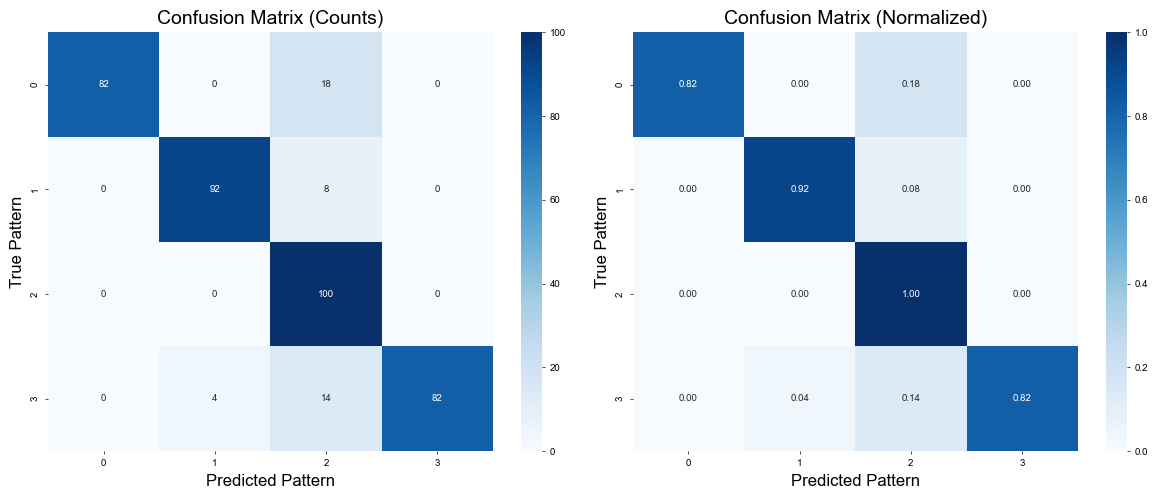

Example trials: [0, 100, 200, 300]


/var/folders/vq/wqh08z6d6wbcm3z2r206cfn00000gn/T/ipykernel_2973/1148679425.py:283: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vq/wqh08z6d6wbcm3z2r206cfn00000gn/T/ipykernel_2973/1148679425.py:283: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


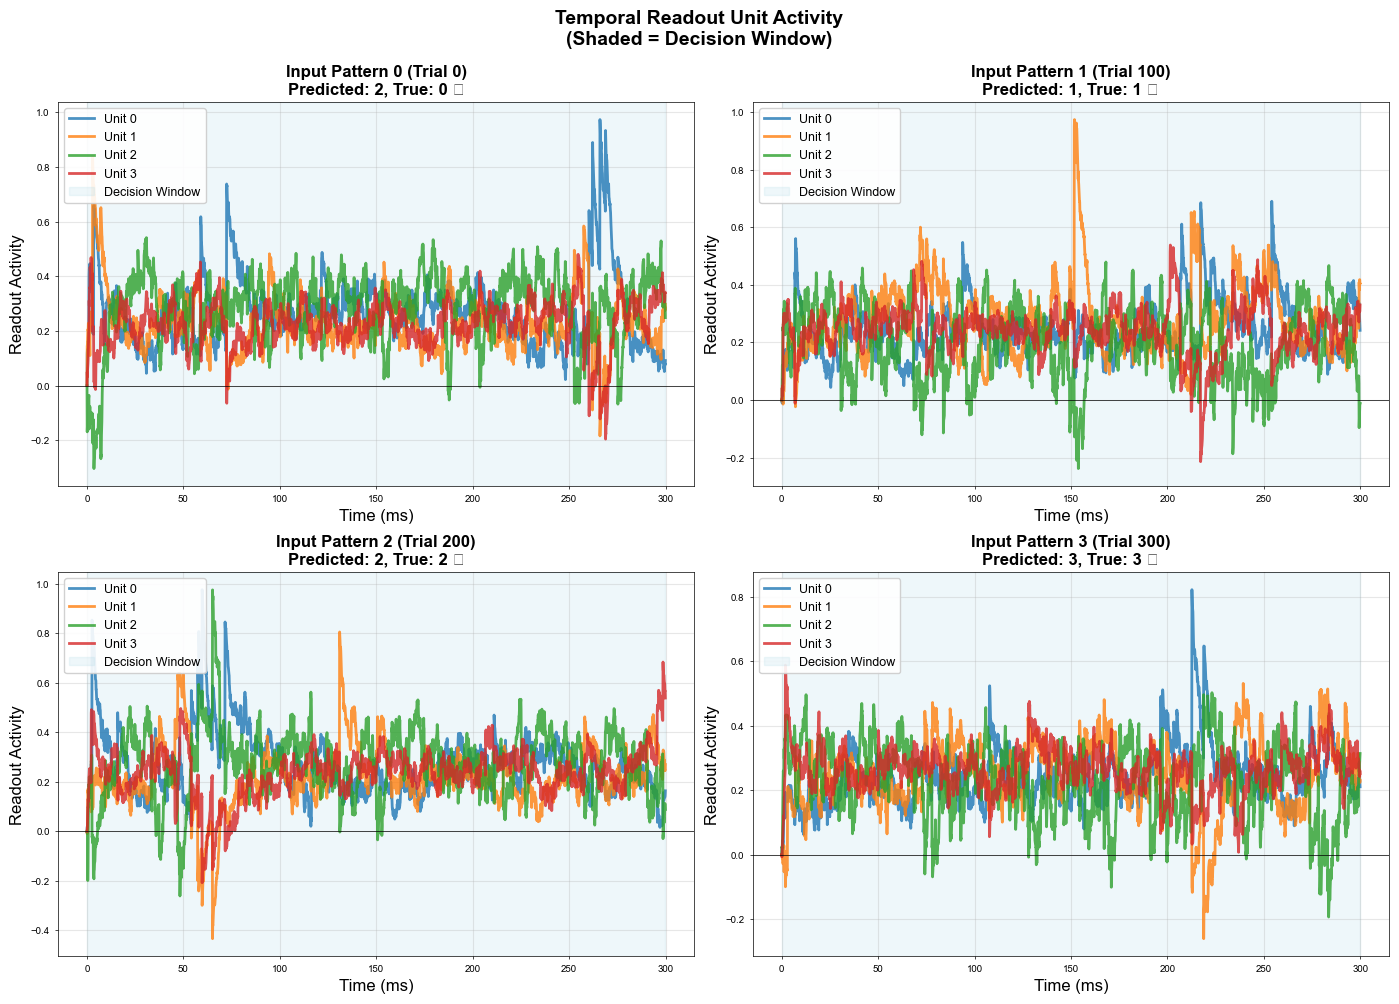

/var/folders/vq/wqh08z6d6wbcm3z2r206cfn00000gn/T/ipykernel_2973/1148679425.py:323: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vq/wqh08z6d6wbcm3z2r206cfn00000gn/T/ipykernel_2973/1148679425.py:323: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()


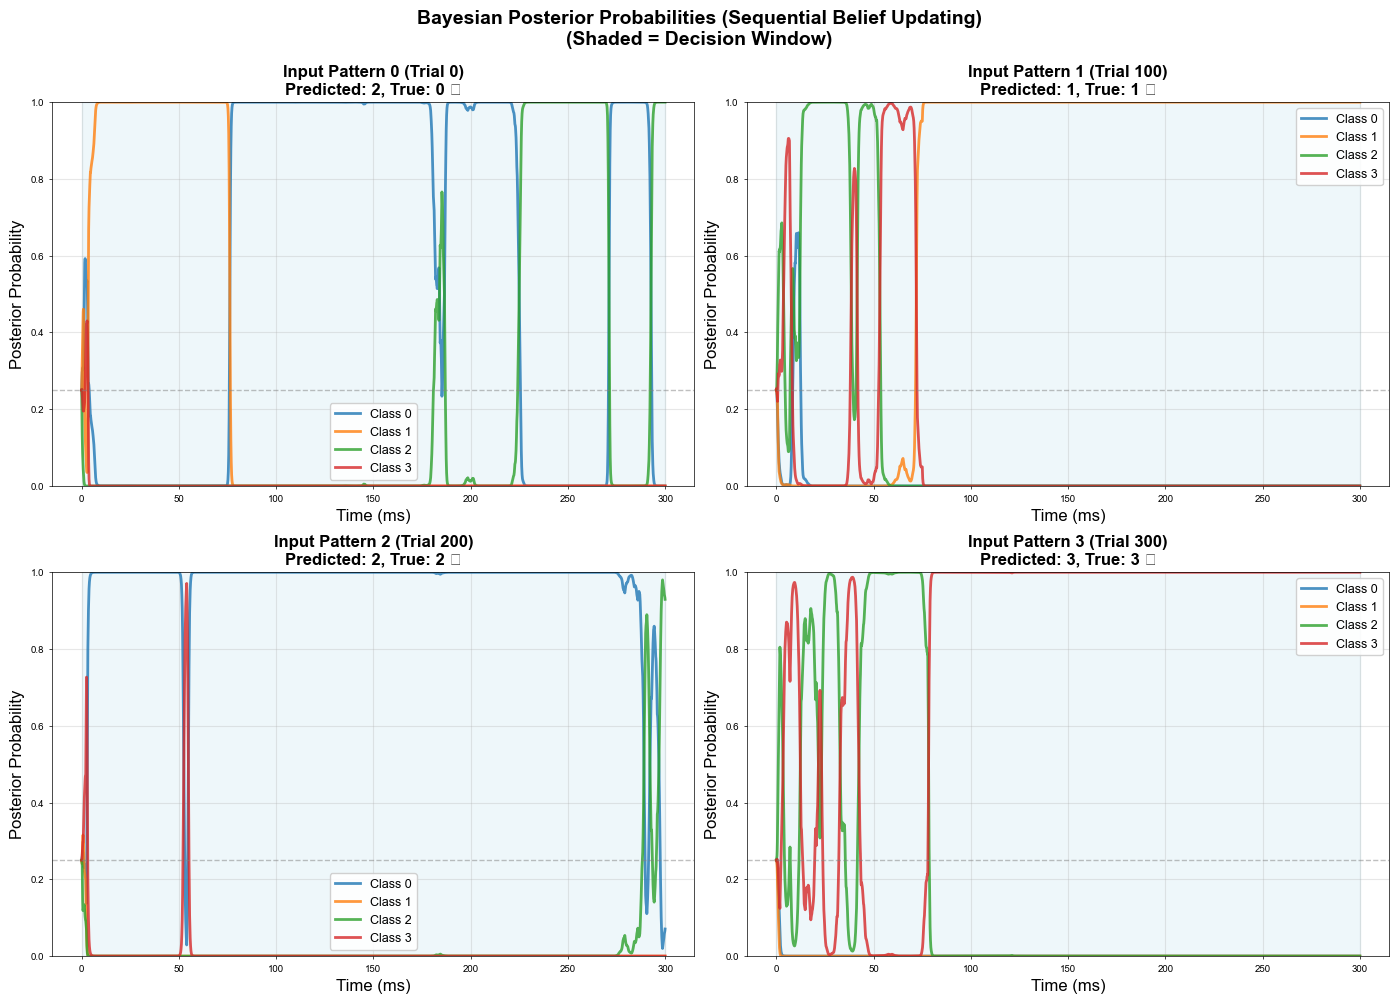

/var/folders/vq/wqh08z6d6wbcm3z2r206cfn00000gn/T/ipykernel_2973/1148679425.py:365: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vq/wqh08z6d6wbcm3z2r206cfn00000gn/T/ipykernel_2973/1148679425.py:365: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vq/wqh08z6d6wbcm3z2r206cfn00000gn/T/ipykernel_2973/1148679425.py:365: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLA

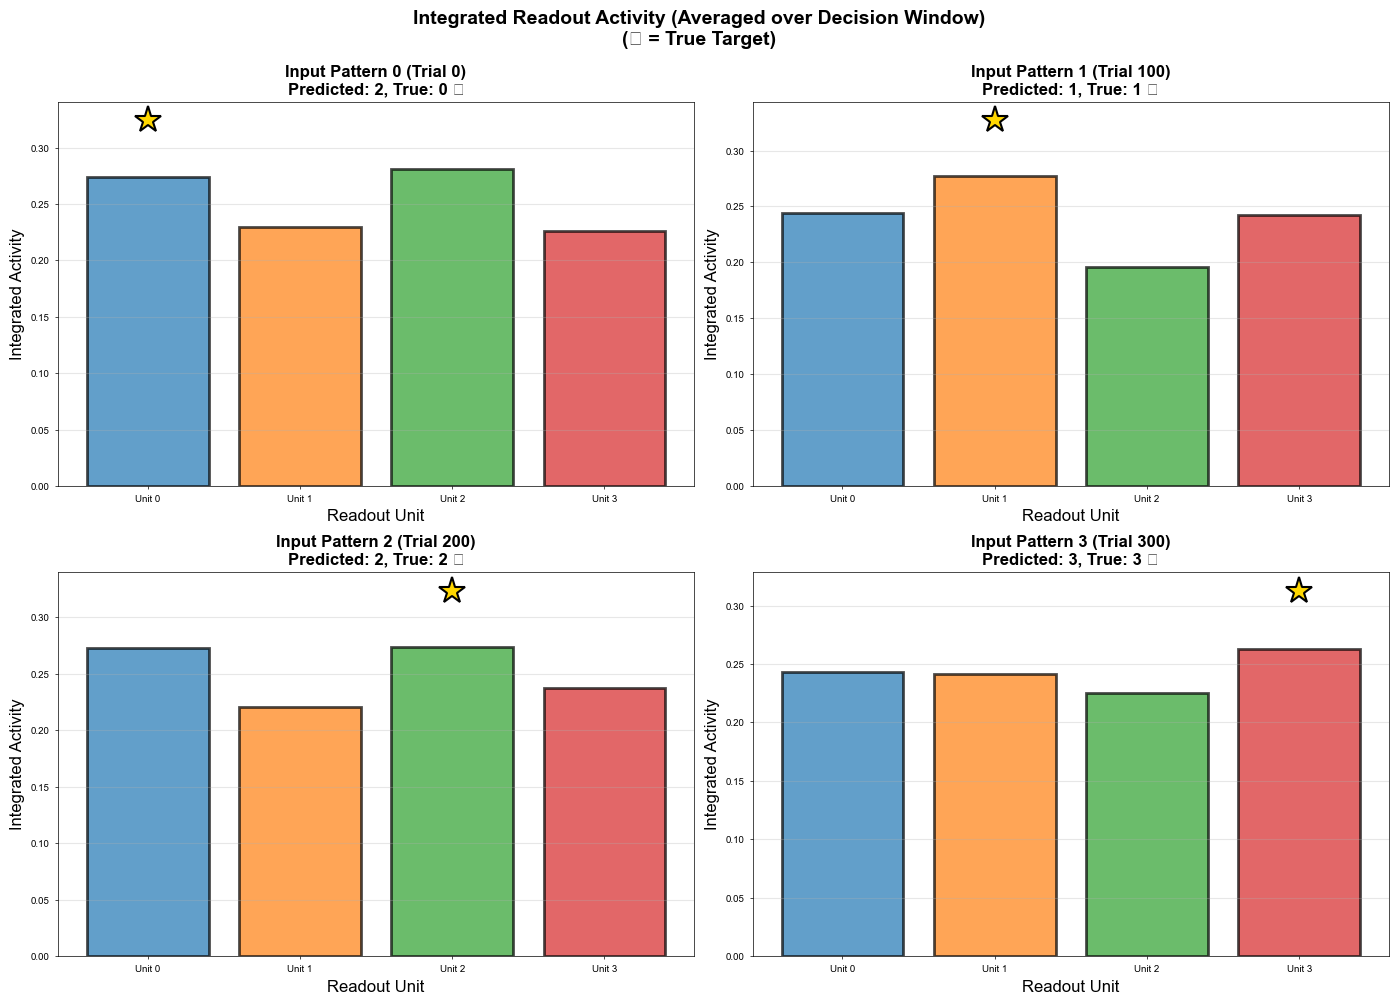

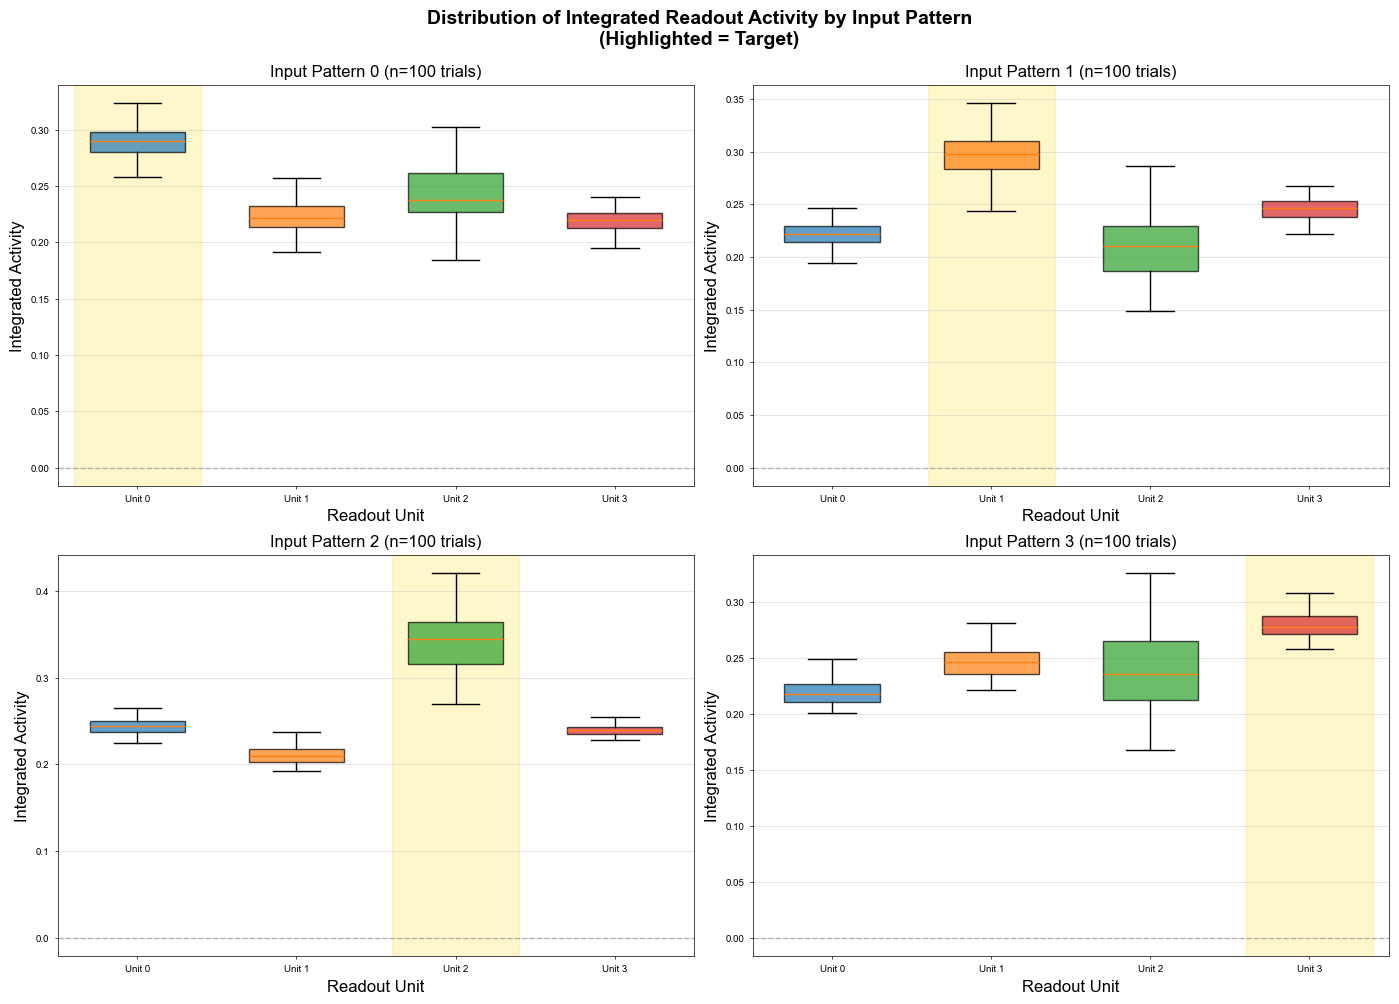


💾 Saving data for future plots...
✓ Data saved to categorical_classification_results.pkl

CATEGORICAL CLASSIFICATION SUMMARY
Network: 1000 neurons, σ_vth=0.0, σ_g=1.0
Task: 4 patterns × 100 trials

First Fold Test Accuracy: 0.900
Overall Accuracy: 0.890
Chance Level: 0.250

Decision method: Average readout activity over 300.0ms window

Per-Pattern Accuracy:
  Pattern 0: 0.820
  Pattern 1: 0.920
  Pattern 2: 1.000
  Pattern 3: 0.820

✅ All visualizations complete!
✅ Data saved to categorical_classification_results.pkl


In [110]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from typing import Dict, List, Tuple
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

# Import your modules
from experiments.task_performance_experiment import TaskPerformanceExperiment
from experiments.experiment_utils import train_task_readout, predict_task_readout, evaluate_categorical_task
from src.rng_utils import get_rng

print("✓ Imports successful!")

# ============================================================================
# PARAMETERS
# ============================================================================
session_id = 0
n_input_patterns = 4
n_neurons = 1000
n_trials = 100
input_hd_dim = 1
embed_dim_input = 4
output_hd_dim = n_input_patterns
synaptic_mode = "filter"
static_input_mode = "common_tonic"
hd_input_mode = "common_tonic"
v_th_distribution = "normal"
v_th_std = 0.0
g_std = 1.0
static_input_rate = 30.0
dt = 0.1
tau_syn = 5.0
transient_time = 500.0
stimulus_duration = 300.0
decision_window = 300.0
lambda_reg = 0.001
n_folds = 20
signal_cache_dir = "/tmp/hd_signals"
os.makedirs(signal_cache_dir, exist_ok=True)

print("✓ Parameters configured!")

# ============================================================================
# INITIALIZE EXPERIMENT
# ============================================================================
experiment = TaskPerformanceExperiment(
    task_type='categorical',
    n_neurons=n_neurons,
    n_input_patterns=n_input_patterns,
    input_dim_intrinsic=input_hd_dim,
    input_dim_embedding=embed_dim_input,
    output_dim_intrinsic=output_hd_dim,
    output_dim_embedding=0,
    dt=dt,
    tau_syn=tau_syn,
    synaptic_mode=synaptic_mode,
    static_input_mode=static_input_mode,
    hd_input_mode=hd_input_mode,
    signal_cache_dir=signal_cache_dir,
    decision_window=decision_window,
    stimulus_duration=stimulus_duration,
    n_trials_per_pattern=n_trials,
    lambda_reg=lambda_reg,
    use_distributed_cv=False
)

print(f"✓ Experiment initialized: {n_input_patterns} patterns × {n_trials} trials = {n_input_patterns * n_trials} total")

# ============================================================================
# GENERATE PATTERNS
# ============================================================================
print("\n📊 Generating HD input patterns...")
input_patterns = experiment.input_generator.initialize_and_get_patterns(
    session_id=session_id,
    hd_dim=input_hd_dim,
    n_patterns=n_input_patterns
)
output_patterns = experiment.generate_output_patterns(session_id)
print(f"✓ Generated {len(input_patterns)} patterns")

# ============================================================================
# SIMULATE TRIALS
# ============================================================================
print(f"\n🧠 Simulating {n_input_patterns * n_trials} trials...")
all_trial_indices = list(range(n_input_patterns * n_trials))
spike_times_all = experiment.simulate_trials_parallel(
    session_id=session_id,
    v_th_std=v_th_std,
    g_std=g_std,
    v_th_distribution=v_th_distribution,
    static_input_rate=static_input_rate,
    my_trial_indices=all_trial_indices,
    input_patterns=input_patterns,
    rank=0
)
spike_counts = [len(trial['spike_times']) for trial in spike_times_all]
print(f"✓ Simulation complete! Mean spikes: {np.mean(spike_counts):.1f} ± {np.std(spike_counts):.1f}")

# ============================================================================
# CONVERT TO TRACES
# ============================================================================
print("\n🔄 Converting spikes to traces...")
traces_all, ground_truth_all, pattern_ids = experiment.convert_spikes_to_traces(
    spike_times_all, output_patterns, n_input_patterns, n_trials
)
print(f"✓ Traces shape: {traces_all.shape}")
print(f"✓ Ground truth shape: {ground_truth_all.shape}")

# ============================================================================
# TRAIN ONLY FIRST CV FOLD
# ============================================================================
print("\n🔧 Training only FIRST CV fold...")

# Get RNG for CV splits (same as in cross_validate)
rng_cv = get_rng(session_id, 0.0, 0.0, 0,
                f'task_categorical_cv_splits',
                hd_dim=input_hd_dim,
                embed_dim=embed_dim_input)
cv_seed = int(rng_cv.integers(0, 2**31 - 1))

# Create stratified folds (same as CV does)
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=cv_seed)
fold_splits = list(skf.split(traces_all, pattern_ids))

# Get ONLY first fold
train_idx, test_idx = fold_splits[0]
print(f"✓ First fold: {len(train_idx)} train, {len(test_idx)} test")

# Split data
X_train = traces_all[train_idx]
X_test = traces_all[test_idx]
y_train = ground_truth_all[train_idx]
y_test = ground_truth_all[test_idx]

# Train readout on first fold
W_readout = train_task_readout(X_train, y_train, lambda_reg)
print(f"✓ Trained readout weights: {W_readout.shape}")

# Predict temporal signals for ALL trials
predictions_temporal = predict_task_readout(traces_all, W_readout)
print(f"✓ Temporal predictions: {predictions_temporal.shape}")

# Evaluate test set
decision_window_steps = int(decision_window / dt)
test_metrics = evaluate_categorical_task(
    predict_task_readout(X_test, W_readout), 
    y_test, 
    decision_window_steps
)
print(f"✓ First fold test accuracy: {test_metrics['accuracy']:.3f}")

# Get predictions for all trials
predictions_decision = predictions_temporal[:, -decision_window_steps:, :]
predictions_integrated = np.mean(predictions_decision, axis=1)
predicted_classes = np.argmax(predictions_integrated, axis=1)
true_classes = np.argmax(ground_truth_all[:, 0, :], axis=1)

overall_accuracy = np.mean(predicted_classes == true_classes)
print(f"✓ Overall accuracy: {overall_accuracy:.3f}")

# ============================================================================
# BAYESIAN POSTERIOR FUNCTION
# ============================================================================
def softmax(x, axis=-1):
    """Compute softmax along specified axis"""
    exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

def bayesian_posterior_update(predictions_temporal_trial, prior=None):
    """
    Compute proper Bayesian posterior probability over time.
    
    At each timestep t:
    P(class|observations up to t) ∝ P(observation_t|class) × P(class|observations up to t-1)
    
    Args:
        predictions_temporal_trial: (time, n_classes) - raw predictions for one trial
        prior: Initial prior probabilities. If None, use uniform prior.
    
    Returns:
        posteriors: (time, n_classes) - posterior probability at each timestep
    """
    n_timesteps, n_classes = predictions_temporal_trial.shape
    
    # Initialize prior (uniform if not provided)
    if prior is None:
        prior = np.ones(n_classes) / n_classes
    
    # Storage for posteriors at each timestep
    posteriors = np.zeros((n_timesteps, n_classes))
    
    # Current belief starts with prior
    current_posterior = prior.copy()
    
    for t in range(n_timesteps):
        # Get likelihood at this timestep (use softmax of raw predictions)
        likelihood = softmax(predictions_temporal_trial[t:t+1], axis=1)[0]
        
        # Bayesian update: posterior ∝ likelihood × prior
        unnormalized_posterior = likelihood * current_posterior
        
        # Normalize to get proper probability distribution
        current_posterior = unnormalized_posterior / (unnormalized_posterior.sum() + 1e-10)
        
        # Store
        posteriors[t] = current_posterior
    
    return posteriors

# ============================================================================
# VISUALIZATION 1: CONFUSION MATRIX
# ============================================================================
print("\n📊 Creating visualizations...")

cm = confusion_matrix(true_classes, predicted_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, 
            xticklabels=range(n_input_patterns), yticklabels=range(n_input_patterns))
ax1.set_xlabel('Predicted Pattern', fontsize=12)
ax1.set_ylabel('True Pattern', fontsize=12)
ax1.set_title('Confusion Matrix (Counts)', fontsize=14)

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax2,
            xticklabels=range(n_input_patterns), yticklabels=range(n_input_patterns))
ax2.set_xlabel('Predicted Pattern', fontsize=12)
ax2.set_ylabel('True Pattern', fontsize=12)
ax2.set_title('Confusion Matrix (Normalized)', fontsize=14)
plt.tight_layout()
plt.show()

# ============================================================================
# VISUALIZATION 2: TEMPORAL READOUT SIGNALS
# ============================================================================
# Select one example trial from each pattern
example_trials = []
for pattern_id in range(n_input_patterns):
    pattern_mask = pattern_ids == pattern_id
    pattern_indices = np.where(pattern_mask)[0]
    example_trials.append(pattern_indices[0])

print(f"Example trials: {example_trials}")

# Create time axis
time_axis = np.arange(predictions_temporal.shape[1]) * dt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, (trial_idx, pattern_id) in enumerate(zip(example_trials, range(n_input_patterns))):
    ax = axes[idx]
    
    # Plot temporal activity for each readout unit
    for readout_unit in range(n_input_patterns):
        temporal_activity = predictions_temporal[trial_idx, :, readout_unit]
        ax.plot(time_axis, temporal_activity, color=colors[readout_unit], 
                linewidth=2, label=f'Unit {readout_unit}', alpha=0.8)
    
    # Mark decision window
    decision_start = time_axis[-decision_window_steps]
    ax.axvspan(decision_start, time_axis[-1], alpha=0.2, color='lightblue', 
               label='Decision Window')
    
    pred_class = predicted_classes[trial_idx]
    true_class = true_classes[trial_idx]
    correct = "✓" if pred_class == true_class else "✗"
    
    ax.set_xlabel('Time (ms)', fontsize=12)
    ax.set_ylabel('Readout Activity', fontsize=12)
    ax.set_title(f'Input Pattern {pattern_id} (Trial {trial_idx})\nPredicted: {pred_class}, True: {true_class} {correct}', 
                fontsize=12, fontweight='bold')
    ax.legend(loc='upper left', fontsize=9, framealpha=0.9)
    ax.grid(alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.suptitle('Temporal Readout Unit Activity\n(Shaded = Decision Window)', 
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ============================================================================
# VISUALIZATION 3: BAYESIAN POSTERIOR PROBABILITIES
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (trial_idx, pattern_id) in enumerate(zip(example_trials, range(n_input_patterns))):
    ax = axes[idx]
    
    # Compute Bayesian posterior
    posterior_probs = bayesian_posterior_update(predictions_temporal[trial_idx])
    
    # Plot posterior probabilities over time
    for readout_unit in range(n_input_patterns):
        ax.plot(time_axis, posterior_probs[:, readout_unit], 
               color=colors[readout_unit], linewidth=2, 
               label=f'Class {readout_unit}', alpha=0.8)
    
    # Mark decision window
    decision_start = time_axis[-decision_window_steps]
    ax.axvspan(decision_start, time_axis[-1], alpha=0.2, color='lightblue')
    
    pred_class = predicted_classes[trial_idx]
    true_class = true_classes[trial_idx]
    correct = "✓" if pred_class == true_class else "✗"
    
    ax.set_xlabel('Time (ms)', fontsize=12)
    ax.set_ylabel('Posterior Probability', fontsize=12)
    ax.set_title(f'Input Pattern {pattern_id} (Trial {trial_idx})\nPredicted: {pred_class}, True: {true_class} {correct}', 
                fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1])
    ax.legend(loc='best', fontsize=9, framealpha=0.9)
    ax.grid(alpha=0.3)
    ax.axhline(y=0.25, color='gray', linestyle='--', alpha=0.5, linewidth=1)

plt.suptitle('Bayesian Posterior Probabilities (Sequential Belief Updating)\n(Shaded = Decision Window)', 
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ============================================================================
# VISUALIZATION 4: INTEGRATED READOUT ACTIVITY (BAR PLOT)
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (trial_idx, pattern_id) in enumerate(zip(example_trials, range(n_input_patterns))):
    ax = axes[idx]
    
    # Get integrated activity for this trial
    integrated_activity = predictions_integrated[trial_idx]
    true_label = ground_truth_all[trial_idx, 0, :]
    
    # Bar plot
    for readout_unit in range(n_input_patterns):
        activity = integrated_activity[readout_unit]
        ax.bar(readout_unit, activity, color=colors[readout_unit], 
               alpha=0.7, edgecolor='black', linewidth=2)
        
        # Mark the true target with a star
        if true_label[readout_unit] == 1.0:
            ax.plot(readout_unit, activity + 0.05, '*', markersize=20, 
                   color='gold', markeredgecolor='black', markeredgewidth=1.5)
    
    pred_class = predicted_classes[trial_idx]
    true_class = true_classes[trial_idx]
    correct = "✓" if pred_class == true_class else "✗"
    
    ax.set_xlabel('Readout Unit', fontsize=12)
    ax.set_ylabel('Integrated Activity', fontsize=12)
    ax.set_title(f'Input Pattern {pattern_id} (Trial {trial_idx})\nPredicted: {pred_class}, True: {true_class} {correct}', 
                fontsize=12, fontweight='bold')
    ax.set_xticks(range(n_input_patterns))
    ax.set_xticklabels([f'Unit {i}' for i in range(n_input_patterns)])
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Integrated Readout Activity (Averaged over Decision Window)\n(★ = True Target)', 
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ============================================================================
# VISUALIZATION 5: DISTRIBUTION BY PATTERN
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for pattern_id in range(n_input_patterns):
    ax = axes[pattern_id]
    pattern_mask = pattern_ids == pattern_id
    pattern_predictions = predictions_integrated[pattern_mask]
    
    positions = range(n_input_patterns)
    data_to_plot = [pattern_predictions[:, i] for i in range(n_input_patterns)]
    
    bp = ax.boxplot(data_to_plot, positions=positions, patch_artist=True, widths=0.6, showfliers=False)
    
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Highlight the correct readout unit
    ax.axvspan(pattern_id - 0.4, pattern_id + 0.4, alpha=0.2, color='gold')
    
    ax.set_xlabel('Readout Unit', fontsize=12)
    ax.set_ylabel('Integrated Activity', fontsize=12)
    ax.set_title(f'Input Pattern {pattern_id} (n={np.sum(pattern_mask)} trials)', fontsize=12)
    ax.set_xticks(range(n_input_patterns))
    ax.set_xticklabels([f'Unit {i}' for i in range(n_input_patterns)])
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Distribution of Integrated Readout Activity by Input Pattern\n(Highlighted = Target)', 
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ============================================================================
# SAVE DATA FOR FUTURE USE
# ============================================================================
import pickle

print("\n💾 Saving data for future plots...")

# Save all important data
data_to_save = {
    'predictions_temporal': predictions_temporal,  # (n_trials, time, n_classes)
    'predictions_integrated': predictions_integrated,  # (n_trials, n_classes)
    'predicted_classes': predicted_classes,  # (n_trials,)
    'true_classes': true_classes,  # (n_trials,)
    'pattern_ids': pattern_ids,  # (n_trials,)
    'W_readout': W_readout,  # (n_neurons, n_classes)
    'time_axis': time_axis,
    'example_trials': example_trials,
    'parameters': {
        'session_id': session_id,
        'n_input_patterns': n_input_patterns,
        'n_neurons': n_neurons,
        'n_trials': n_trials,
        'input_hd_dim': input_hd_dim,
        'embed_dim_input': embed_dim_input,
        'dt': dt,
        'stimulus_duration': stimulus_duration,
        'decision_window': decision_window,
        'lambda_reg': lambda_reg,
        'v_th_std': v_th_std,
        'g_std': g_std,
        'static_input_rate': static_input_rate
    },
    'accuracy': overall_accuracy
}

output_file = 'categorical_classification_results.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(data_to_save, f)

print(f"✓ Data saved to {output_file}")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*70)
print("CATEGORICAL CLASSIFICATION SUMMARY")
print("="*70)
print(f"Network: {n_neurons} neurons, σ_vth={v_th_std}, σ_g={g_std}")
print(f"Task: {n_input_patterns} patterns × {n_trials} trials")
print(f"\nFirst Fold Test Accuracy: {test_metrics['accuracy']:.3f}")
print(f"Overall Accuracy: {overall_accuracy:.3f}")
print(f"Chance Level: {1.0/n_input_patterns:.3f}")
print(f"\nDecision method: Average readout activity over {decision_window}ms window")
print("\nPer-Pattern Accuracy:")
for pattern_id in range(n_input_patterns):
    mask = pattern_ids == pattern_id
    pattern_acc = np.mean(predicted_classes[mask] == true_classes[mask])
    print(f"  Pattern {pattern_id}: {pattern_acc:.3f}")
print("="*70)
print("\n✅ All visualizations complete!")
print(f"✅ Data saved to {output_file}")

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

def softmax(x, axis=-1):
    """Compute softmax along specified axis"""
    exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

def bayesian_posterior_update(predictions_temporal_trial, prior=None):
    """
    Compute proper Bayesian posterior probability over time.
    
    At each timestep t:
    P(class|observations up to t) ∝ P(observation_t|class) × P(class|observations up to t-1)
    
    Args:
        predictions_temporal_trial: (time, n_classes) - raw predictions for one trial
        prior: Initial prior probabilities. If None, use uniform prior.
    
    Returns:
        posteriors: (time, n_classes) - posterior probability at each timestep
    """
    n_timesteps, n_classes = predictions_temporal_trial.shape
    
    # Initialize prior (uniform if not provided)
    if prior is None:
        prior = np.ones(n_classes) / n_classes
    
    # Storage for posteriors at each timestep
    posteriors = np.zeros((n_timesteps, n_classes))
    
    # Current belief starts with prior
    current_posterior = prior.copy()
    
    for t in range(n_timesteps):
        # Get likelihood at this timestep (use softmax of raw predictions)
        likelihood = softmax(predictions_temporal_trial[t:t+1], axis=1)[0]
        
        # Bayesian update: posterior ∝ likelihood × prior
        unnormalized_posterior = likelihood * current_posterior
        
        # Normalize to get proper probability distribution
        current_posterior = unnormalized_posterior / (unnormalized_posterior.sum() + 1e-10)
        
        # Store
        posteriors[t] = current_posterior
    
    return posteriors
    
    
output_file = 'categorical_classification_results.pkl'
with open(output_file, 'rb') as f:
    loaded_data = pickle.load(f)

predictions_temporal = loaded_data["predictions_temporal"]

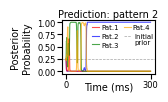

In [5]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
trial_idx = 100
dt = 0.1
# output_file = f'trial_{trial_idx}_accumulated_probs.pkl'
# with open(output_file, 'rb') as f:
#     loaded_data = pickle.load(f)
# time_axis = loaded_data['time_axis']
# running_avg_probs = loaded_data['accumulated_probability']
predicted_classes = 2
true_classes = 2
fig, ax = plt.subplots(figsize=(1.2, 0.7))
time_axis = np.arange(3000) * dt

# Plot in order: Pat.1, Pat.2, Pat.4, empty, Pat.3, Chance

posterior_probs = bayesian_posterior_update(predictions_temporal[100])

ax.plot(time_axis, posterior_probs[:, 0], color="r", linewidth=0.8, label='Pat.1', alpha=0.7,zorder=10)
ax.plot(time_axis, posterior_probs[:, 1], color="b", linewidth=0.8, label='Pat.2', alpha=0.7,zorder=1)
ax.plot(time_axis, posterior_probs[:, 2], color="g", linewidth=0.8, label='Pat.3', alpha=0.7,zorder=10)
ax.plot(time_axis, posterior_probs[:, 3], color="orange", linewidth=0.8, label='Pat.4', alpha=0.7,zorder=10)

ax.axhline(y=0.25, color='gray', linestyle='--', linewidth=0.5, alpha=0.7, label=' ')

ax.set_xlabel('Time (ms)', fontsize=7, labelpad=-5)
ax.set_ylabel('Posterior\nProbability', fontsize=7, labelpad=4)
ax.set_title(f'Prediction: pattern 2', fontsize=7, pad=2)
ax.legend(
    fontsize=5,
    ncol=2,
    frameon=False,
    loc='upper right',  
    borderpad=0.5,
    handlelength=1,
    handletextpad=0.3,
    columnspacing=0.7,
    borderaxespad=0.15,
    labelspacing=0.4
)
ax.text(242, 0.67, 'Initial', fontsize=5) 
ax.text(242, 0.55, 'prior', fontsize=5) 

ax.tick_params(labelsize=6)
ax.set_yticks([0.,0.25,0.5,0.75,1])
# ax.set_ylim([0.225,0.285])
ax.set_xticks([0, 300])
ax.tick_params(pad=1)
plt.savefig('accumulated_probability.svg', format='svg', dpi=450, bbox_inches='tight')
plt.savefig('accumulated_probability.pdf', format='pdf', dpi=450, bbox_inches='tight')
plt.show()

In [8]:
posterior_probs[-1:, 3]

array([1.09950809e-45])

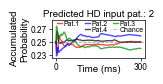

In [108]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
trial_idx = 100
dt = 0.1
output_file = f'trial_{trial_idx}_accumulated_probs.pkl'
with open(output_file, 'rb') as f:
    loaded_data = pickle.load(f)
time_axis = loaded_data['time_axis']
running_avg_probs = loaded_data['accumulated_probability']
predicted_classes = 2
true_classes = 2
fig, ax = plt.subplots(figsize=(1.2, 0.5))
time_axis = np.arange(running_avg_probs.shape[0]) * dt

# Plot in order: Pat.1, Pat.2, Pat.4, empty, Pat.3, Chance
ax.plot(time_axis, running_avg_probs[:, 0], "r", linewidth=1, label='Pat.1',alpha=0.7)
ax.plot([], [], ' ', label=' ')  # Empty
ax.plot(time_axis, running_avg_probs[:, 1], "b", linewidth=1, label='Pat.2',alpha=0.7)
ax.plot(time_axis, running_avg_probs[:, 3], "k", linewidth=1, label='Pat.4',alpha=0.7)

ax.plot(time_axis, running_avg_probs[:, 2], "g", linewidth=1, label='Pat.3',alpha=0.7)
ax.axhline(y=0.25, color='gray', linestyle='--', linewidth=0.6, alpha=0.7, label='Chance')

ax.set_xlabel('Time (ms)', fontsize=7, labelpad=-5)
ax.set_ylabel('Accumulated\nProbability', fontsize=7, labelpad=1)
ax.set_title(f'Predicted HD input pat.: 2', fontsize=7, pad=2)
ax.legend(
    fontsize=5,
    ncol=3,
    frameon=False,
    loc='best',
    borderpad=0,
    handlelength=0.7,
    handletextpad=0.3,
    columnspacing=0.7,
    borderaxespad=0.15,
    labelspacing=0.
)
ax.tick_params(labelsize=6)
ax.set_yticks([0.23,0.25,0.27])
ax.set_ylim([0.225,0.285])
ax.set_xticks([0, 300])
ax.tick_params(pad=1)
plt.savefig('accumulated_probability.svg', format='svg', dpi=450, bbox_inches='tight')
plt.show()

In [109]:
def bayesian_posterior_update(predictions_temporal_trial, prior=None):
    """
    Compute proper Bayesian posterior probability over time.
    
    At each timestep t:
    P(class|observations up to t) ∝ P(observation_t|class) × P(class|observations up to t-1)
    
    Args:
        predictions_temporal_trial: (time, n_classes) - raw predictions for one trial
        prior: Initial prior probabilities. If None, use uniform prior.
    
    Returns:
        posteriors: (time, n_classes) - posterior probability at each timestep
    """
    n_timesteps, n_classes = predictions_temporal_trial.shape
    
    # Initialize prior (uniform if not provided)
    if prior is None:
        prior = np.ones(n_classes) / n_classes
    
    # Storage for posteriors at each timestep
    posteriors = np.zeros((n_timesteps, n_classes))
    
    # Current belief starts with prior
    current_posterior = prior.copy()
    
    for t in range(n_timesteps):
        # Get likelihood at this timestep (use softmax of raw predictions)
        likelihood = softmax(predictions_temporal_trial[t:t+1], axis=1)[0]
        
        # Bayesian update: posterior ∝ likelihood × prior
        unnormalized_posterior = likelihood * current_posterior
        
        # Normalize to get proper probability distribution
        current_posterior = unnormalized_posterior / (unnormalized_posterior.sum() + 1e-10)
        
        # Store
        posteriors[t] = current_posterior
    
    return posteriors


# Example usage
trial_idx = 100

# Compute proper Bayesian posterior
posterior_probs = bayesian_posterior_update(predictions_temporal[trial_idx])

# Plot
plt.figure(figsize=(10, 6))
time_axis = np.arange(posterior_probs.shape[0]) * dt
plt.plot(time_axis, posterior_probs[:, 0], "r", linewidth=2, label='Class 0')
plt.plot(time_axis, posterior_probs[:, 1], "b", linewidth=2, label='Class 1')
plt.plot(time_axis, posterior_probs[:, 2], "g", linewidth=2, label='Class 2')
plt.plot(time_axis, posterior_probs[:, 3], "k", linewidth=2, label='Class 3')
plt.xlabel('Time (ms)', fontsize=12)
plt.ylabel('Posterior Probability', fontsize=12)
plt.title(f'Trial {trial_idx}: True class={true_classes[trial_idx]} (Bayesian Update)', 
         fontsize=14)
plt.ylim([0, 1])
plt.legend()
plt.grid(alpha=0.3)
plt.axhline(y=0.25, color='gray', linestyle='--', alpha=0.5, label='Prior (0.25)')
plt.show()

# Verify they sum to 1 at each timestep
print(f"Posterior sum at t=0: {posterior_probs[0].sum():.6f}")
print(f"Posterior sum at t=-1: {posterior_probs[-1].sum():.6f}")

# Compare final posteriors
print(f"\nFinal posterior probabilities:")
for i in range(n_input_patterns):
    print(f"  Class {i}: {posterior_probs[-1, i]:.4f}")
print(f"\nPredicted class: {np.argmax(posterior_probs[-1])}")
print(f"True class: {true_classes[trial_idx]}")

NameError: name 'predictions_temporal' is not defined

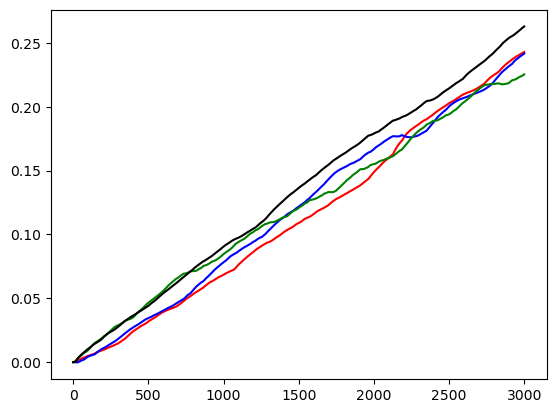

In [46]:
plt.plot(np.cumsum(predictions_temporal[300,:,0])/3000,"r")
plt.plot(np.cumsum(predictions_temporal[300,:,1])/3000,"b")
plt.plot(np.cumsum(predictions_temporal[300,:,2])/3000,"g")
plt.plot(np.cumsum(predictions_temporal[300,:,3])/3000,"k")

In [22]:
np.cumsum(predictions_temporal[300,:,0])[-1]/3000

0.24296036897379553

In [23]:
np.cumsum(predictions_temporal[300,:,1])[-1]/3000

0.24173698530824683

In [24]:
np.cumsum(predictions_temporal[300,:,2])[-1]/3000

0.22540642573305847

In [25]:
np.cumsum(predictions_temporal[300,:,3])[-1]/3000

0.262935911861294

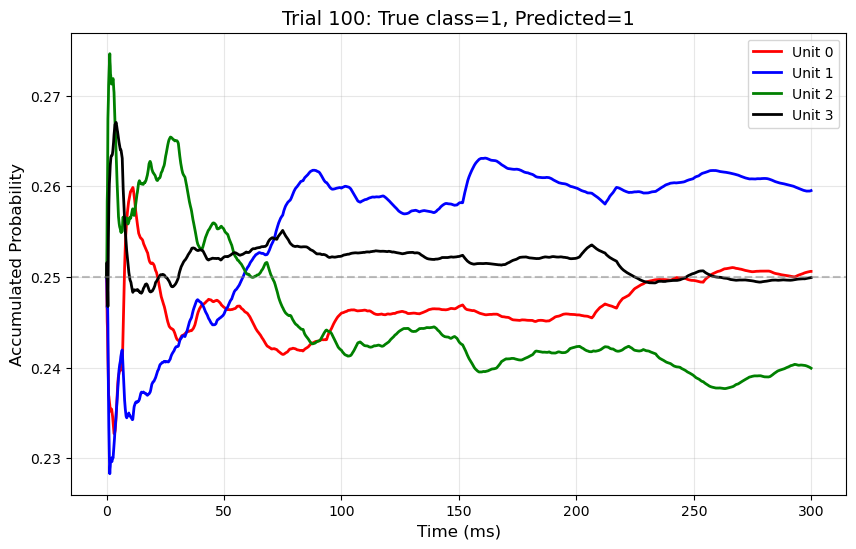

Running avg probs sum at t=-1: 1.000000


In [61]:
trial_idx = 100

# Step 1: Softmax at each timestep
predictions_probs = softmax(predictions_temporal[trial_idx], axis=1)  # (time, n_classes)

# Step 2: Cumulative sum of probabilities
cumulative_probs = np.cumsum(predictions_probs, axis=0)  # (time, n_classes)

# Step 3: Divide by time index to get running average
time_indices = np.arange(1, cumulative_probs.shape[0] + 1)[:, np.newaxis]  # (time, 1)
running_avg_probs = cumulative_probs / time_indices  # (time, n_classes)

# Plot
plt.figure(figsize=(10, 6))
time_axis = np.arange(running_avg_probs.shape[0]) * dt
plt.plot(time_axis, running_avg_probs[:, 0], "r", linewidth=2, label='Unit 0')
plt.plot(time_axis, running_avg_probs[:, 1], "b", linewidth=2, label='Unit 1')
plt.plot(time_axis, running_avg_probs[:, 2], "g", linewidth=2, label='Unit 2')
plt.plot(time_axis, running_avg_probs[:, 3], "k", linewidth=2, label='Unit 3')
plt.xlabel('Time (ms)', fontsize=12)
plt.ylabel('Accumulated Probability', fontsize=12)
plt.title(f'Trial {trial_idx}: True class={true_classes[trial_idx]}, Predicted={predicted_classes[trial_idx]}', 
         fontsize=14)
# plt.ylim([0, 1])
plt.legend()
plt.grid(alpha=0.3)
plt.axhline(y=0.25, color='gray', linestyle='--', alpha=0.5, label='Chance (0.25)')
plt.show()

# Verify they sum to 1
print(f"Running avg probs sum at t=-1: {running_avg_probs[-1].sum():.6f}")  # Should be 1.0

In [52]:
for idx, (trial_idx, pattern_id) in enumerate(zip(example_trials, range(n_input_patterns))):
    print(trial_idx)

0
100
200
300


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from typing import Dict, List, Tuple
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Ridge
import seaborn as sns

# Import your modules with correct path structure
from experiments.task_performance_experiment import TaskPerformanceExperiment

print("✓ Imports successful!")

# ============================================================================
# PARAMETERS
# ============================================================================
session_id = 0
n_input_patterns = 4
n_neurons = 1000
n_trials = 100
input_hd_dim = 4
embed_dim_input = 4
output_hd_dim = n_input_patterns
synaptic_mode = "filter"
static_input_mode = "common_tonic"
hd_input_mode = "common_tonic"
v_th_distribution = "normal"
v_th_std = 0.0
g_std = 1.0
static_input_rate = 30.0
static_input_strength = 10.0
hd_connection_prob = 0.3
hd_input_strength = 50.0
dt = 0.1
tau_syn = 5.0
transient_time = 500.0
stimulus_duration = 300.0
decision_window = 300.0
lambda_reg = 0.001
n_folds = 20
signal_cache_dir = "/tmp/hd_signals"
os.makedirs(signal_cache_dir, exist_ok=True)

print("✓ Parameters configured!")

# ============================================================================
# INITIALIZE EXPERIMENT
# ============================================================================
experiment = TaskPerformanceExperiment(
    task_type='categorical',
    n_neurons=n_neurons,
    n_input_patterns=n_input_patterns,
    input_dim_intrinsic=input_hd_dim,
    input_dim_embedding=embed_dim_input,
    output_dim_intrinsic=output_hd_dim,
    output_dim_embedding=0,
    dt=dt,
    tau_syn=tau_syn,
    synaptic_mode=synaptic_mode,
    static_input_mode=static_input_mode,
    hd_input_mode=hd_input_mode,
    signal_cache_dir=signal_cache_dir,
    decision_window=decision_window,
    stimulus_duration=stimulus_duration,
    n_trials_per_pattern=n_trials,
    lambda_reg=lambda_reg,
    use_distributed_cv=False
)

print(f"✓ Experiment initialized: {n_input_patterns} patterns × {n_trials} trials = {n_input_patterns * n_trials} total")

# ============================================================================
# GENERATE PATTERNS
# ============================================================================
print("\n📊 Generating HD input patterns...")
input_patterns = experiment.input_generator.initialize_and_get_patterns(
    session_id=session_id,
    hd_dim=input_hd_dim,
    n_patterns=n_input_patterns
)
output_patterns = experiment.generate_output_patterns(session_id)
print(f"✓ Generated {len(input_patterns)} patterns")

# ============================================================================
# SIMULATE TRIALS
# ============================================================================
print(f"\n🧠 Simulating {n_input_patterns * n_trials} trials...")
all_trial_indices = list(range(n_input_patterns * n_trials))
spike_times_all = experiment.simulate_trials_parallel(
    session_id=session_id,
    v_th_std=v_th_std,
    g_std=g_std,
    v_th_distribution=v_th_distribution,
    static_input_rate=static_input_rate,
    my_trial_indices=all_trial_indices,
    input_patterns=input_patterns,
    rank=0
)
spike_counts = [len(trial['spike_times']) for trial in spike_times_all]
print(f"✓ Simulation complete! Mean spikes: {np.mean(spike_counts):.1f} ± {np.std(spike_counts):.1f}")

# ============================================================================
# CONVERT TO TRACES
# ============================================================================
print("\n🔄 Converting spikes to traces...")
traces_all, ground_truth_all, pattern_ids = experiment.convert_spikes_to_traces(
    spike_times_all, output_patterns, n_input_patterns, n_trials
)
print(f"✓ Traces shape: {traces_all.shape}")

# ============================================================================
# CROSS-VALIDATION
# ============================================================================
print(f"\n🎯 Training decoder with {n_folds}-fold CV...")
cv_results = experiment.cross_validate(
    traces_all=traces_all,
    ground_truth_all=ground_truth_all,
    pattern_ids=pattern_ids,
    session_id=session_id,
    n_folds=n_folds,
    rank=0,
    size=1,
    comm=None
)
print(f"\n✓ Test Accuracy: {cv_results['test_accuracy_mean']:.3f} ± {cv_results['test_accuracy_std']:.3f}")
print(f"✓ Train Accuracy: {cv_results['train_accuracy_mean']:.3f} ± {cv_results['train_accuracy_std']:.3f}")

# ============================================================================
# TRAIN FINAL DECODER
# ============================================================================
print("\n🔧 Training final decoder on all data...")
decoder = Ridge(alpha=lambda_reg, fit_intercept=True)
decoder.fit(traces_all, ground_truth_all)
predictions = decoder.predict(traces_all)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(ground_truth_all, axis=1)
accuracy = np.mean(predicted_classes == true_classes)
print(f"✓ Overall accuracy: {accuracy:.3f}")

# ============================================================================
# VISUALIZATION 1: CONFUSION MATRIX
# ============================================================================
cm = confusion_matrix(true_classes, predicted_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, 
            xticklabels=range(n_input_patterns), yticklabels=range(n_input_patterns))
ax1.set_xlabel('Predicted Pattern', fontsize=12)
ax1.set_ylabel('True Pattern', fontsize=12)
ax1.set_title('Confusion Matrix (Counts)', fontsize=14)

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax2,
            xticklabels=range(n_input_patterns), yticklabels=range(n_input_patterns))
ax2.set_xlabel('Predicted Pattern', fontsize=12)
ax2.set_ylabel('True Pattern', fontsize=12)
ax2.set_title('Confusion Matrix (Normalized)', fontsize=14)
plt.tight_layout()
plt.show()

# ============================================================================
# VISUALIZATION 2: READOUT UNIT ACTIVITY (YOUR KEY PLOT!)
# ============================================================================
example_trials = []
for pattern_id in range(n_input_patterns):
    pattern_mask = pattern_ids == pattern_id
    pattern_indices = np.where(pattern_mask)[0]
    example_trials.append(pattern_indices[0])

example_predictions = predictions[example_trials]
example_true = ground_truth_all[example_trials]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, (trial_idx, pattern_id) in enumerate(zip(example_trials, range(n_input_patterns))):
    ax = axes[idx]
    for readout_unit in range(n_input_patterns):
        activity = example_predictions[idx, readout_unit]
        true_value = example_true[idx, readout_unit]
        ax.bar(readout_unit, activity, color=colors[readout_unit], 
               alpha=0.7, edgecolor='black', linewidth=2)
        if true_value == 1.0:
            ax.plot(readout_unit, activity + 0.05, '*', markersize=20, 
                   color='gold', markeredgecolor='black', markeredgewidth=1.5)
    
    pred_class = predicted_classes[trial_idx]
    true_class = true_classes[trial_idx]
    correct = "✓" if pred_class == true_class else "✗"
    ax.set_xlabel('Readout Unit', fontsize=12)
    ax.set_ylabel('Activity', fontsize=12)
    ax.set_title(f'Input Pattern {pattern_id} (Trial {trial_idx})\nPredicted: {pred_class}, True: {true_class} {correct}', fontsize=12)
    ax.set_xticks(range(n_input_patterns))
    ax.set_xticklabels([f'Unit {i}' for i in range(n_input_patterns)])
    ax.set_ylim([0, 1.2])
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Readout Unit Activity for Example Trials\n(★ = True Target)', 
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ============================================================================
# VISUALIZATION 3: DISTRIBUTION BY PATTERN
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for pattern_id in range(n_input_patterns):
    ax = axes[pattern_id]
    pattern_mask = pattern_ids == pattern_id
    pattern_predictions = predictions[pattern_mask]
    positions = range(n_input_patterns)
    data_to_plot = [pattern_predictions[:, i] for i in range(n_input_patterns)]
    bp = ax.boxplot(data_to_plot, positions=positions, patch_artist=True, widths=0.6, showfliers=False)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax.axvspan(pattern_id - 0.4, pattern_id + 0.4, alpha=0.2, color='gold')
    ax.set_xlabel('Readout Unit', fontsize=12)
    ax.set_ylabel('Activity', fontsize=12)
    ax.set_title(f'Input Pattern {pattern_id} (n={np.sum(pattern_mask)} trials)', fontsize=12)
    ax.set_xticks(range(n_input_patterns))
    ax.set_xticklabels([f'Unit {i}' for i in range(n_input_patterns)])
    ax.set_ylim([0, 1.2])
    ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Distribution of Readout Unit Activity by Input Pattern\n(Highlighted = Target)', 
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ============================================================================
# VISUALIZATION 4: SPIKE RASTERS
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (trial_idx, pattern_id) in enumerate(zip(example_trials, range(n_input_patterns))):
    ax = axes[idx]
    spikes = spike_times_all[trial_idx]['spike_times']
    if len(spikes) > 0:
        spike_times = [s[0] for s in spikes]
        neuron_ids = [s[1] for s in spikes]
        ax.scatter(spike_times, neuron_ids, s=0.5, c='black', alpha=0.5)
    ax.axvspan(transient_time, transient_time + stimulus_duration, alpha=0.2, color='yellow', label='Stimulus')
    ax.axvspan(transient_time + stimulus_duration - decision_window, 
              transient_time + stimulus_duration, alpha=0.2, color='lightblue', label='Decision Window')
    pred_class = predicted_classes[trial_idx]
    true_class = true_classes[trial_idx]
    correct = "✓" if pred_class == true_class else "✗"
    ax.set_xlabel('Time (ms)', fontsize=12)
    ax.set_ylabel('Neuron ID', fontsize=12)
    ax.set_title(f'Pattern {pattern_id} Spike Raster\nPred: {pred_class}, True: {true_class} {correct}', fontsize=12)
    ax.set_xlim([0, transient_time + stimulus_duration])
    ax.set_ylim([0, n_neurons])
    if idx == 0:
        ax.legend(loc='upper right', fontsize=10)

plt.suptitle('Example Spike Rasters for Each Input Pattern', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*60)
print("CATEGORICAL CLASSIFICATION SUMMARY")
print("="*60)
print(f"Network: {n_neurons} neurons, σ_vth={v_th_std}, σ_g={g_std}")
print(f"Task: {n_input_patterns} patterns × {n_trials} trials")
print(f"Test Accuracy: {cv_results['test_accuracy_mean']:.3f} ± {cv_results['test_accuracy_std']:.3f}")
print(f"Chance Level: {1.0/n_input_patterns:.3f}")
print("\nPer-Pattern Accuracy:")
for pattern_id in range(n_input_patterns):
    mask = pattern_ids == pattern_id
    pattern_acc = np.mean(predicted_classes[mask] == true_classes[mask])
    print(f"  Pattern {pattern_id}: {pattern_acc:.3f}")
print("="*60)

✓ Imports successful!
✓ Parameters configured!
✓ Experiment initialized: 4 patterns × 100 trials = 400 total

📊 Generating HD input patterns...
✓ Generated 4 patterns

🧠 Simulating 400 trials...
   Rank 0: completed 20/400 trials
   Rank 0: completed 40/400 trials
   Rank 0: completed 60/400 trials
   Rank 0: completed 80/400 trials
   Rank 0: completed 100/400 trials
   Rank 0: completed 120/400 trials
   Rank 0: completed 140/400 trials
   Rank 0: completed 160/400 trials
   Rank 0: completed 180/400 trials
   Rank 0: completed 200/400 trials
   Rank 0: completed 220/400 trials
   Rank 0: completed 240/400 trials
   Rank 0: completed 260/400 trials
   Rank 0: completed 280/400 trials
   Rank 0: completed 300/400 trials
   Rank 0: completed 320/400 trials
   Rank 0: completed 340/400 trials
   Rank 0: completed 360/400 trials
   Rank 0: completed 380/400 trials
   Rank 0: completed 400/400 trials
✓ Simulation complete! Mean spikes: 21858.9 ± 942.3

🔄 Converting spikes to traces...
✓ T

ValueError: Found array with dim 3. Ridge expected <= 2.

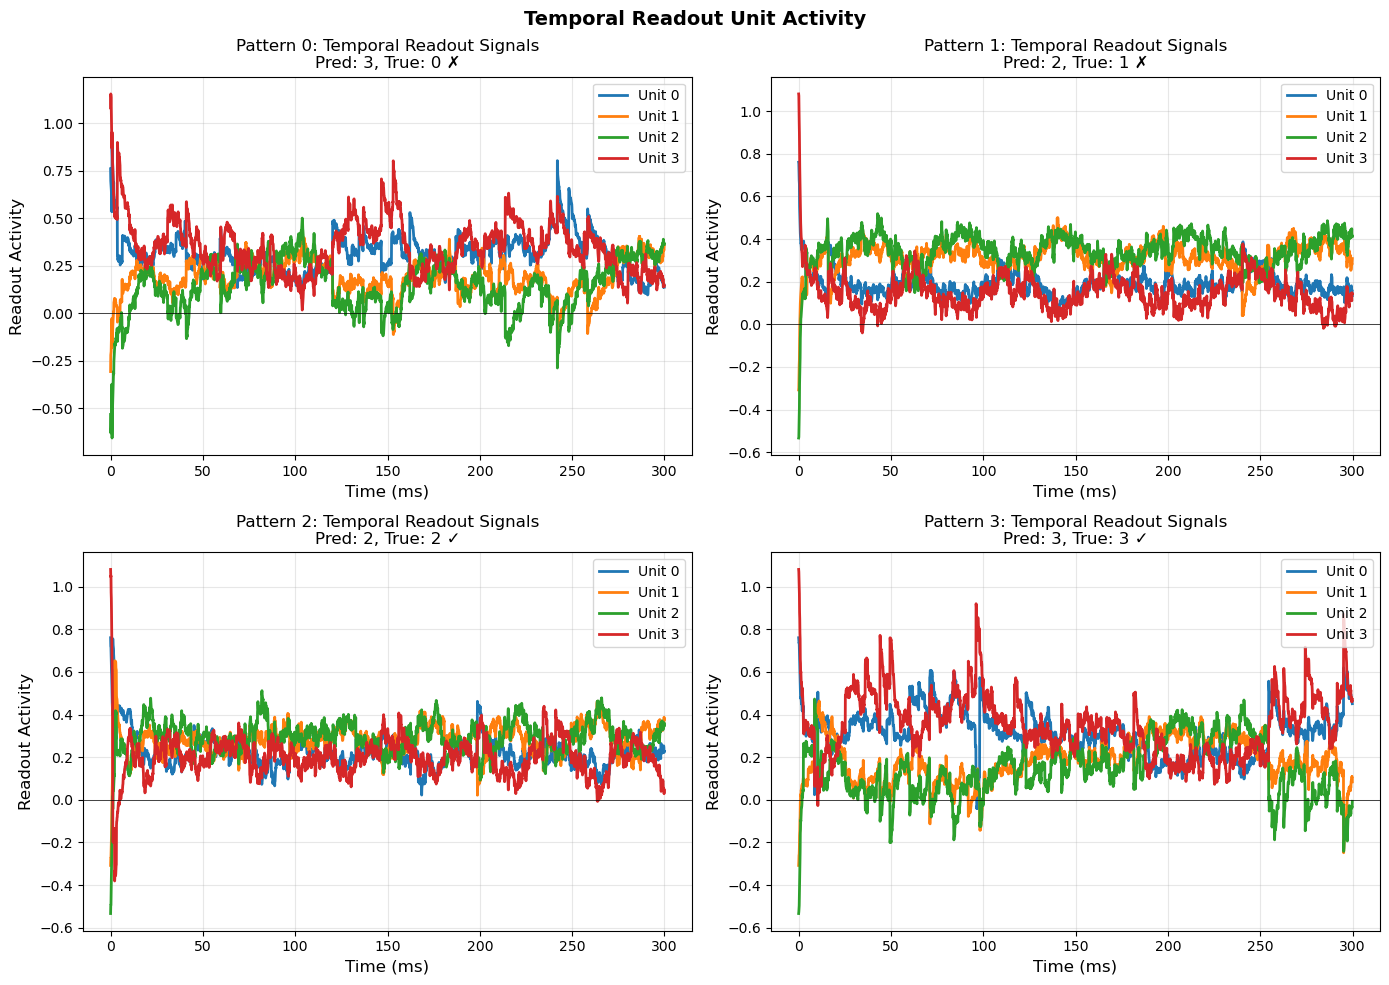

In [12]:
# Train decoder that preserves temporal structure
# We need to train separate decoders for each timepoint OR use a different approach

# Let's reshape to train: (n_trials * n_timesteps, n_neurons) -> (n_trials * n_timesteps, n_classes)
n_trials, n_timesteps, n_neurons = traces_all.shape
_, _, n_classes = ground_truth_all.shape

# Reshape for training
X_flat = traces_all.reshape(-1, n_neurons)  # (trials*time, neurons)
y_flat = ground_truth_all.reshape(-1, n_classes)  # (trials*time, classes)

# Train on first fold
X_train_flat = X_flat[train_idx[0] * n_timesteps : train_idx[-1] * n_timesteps + n_timesteps]
y_train_flat = y_flat[train_idx[0] * n_timesteps : train_idx[-1] * n_timesteps + n_timesteps]

decoder = Ridge(alpha=lambda_reg, fit_intercept=True)
decoder.fit(X_train_flat, y_train_flat)

# Predict full temporal signals
predictions_flat = decoder.predict(X_flat)
predictions_temporal = predictions_flat.reshape(n_trials, n_timesteps, n_classes)

# Integrate over time to get class scores
predictions_integrated = np.sum(predictions_temporal, axis=1)  # (trials, classes)
predicted_classes = np.argmax(predictions_integrated, axis=1)
true_classes = np.argmax(ground_truth_all[:, 0, :], axis=1)

# Now visualize temporal predictions for example trials
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

time_axis = np.arange(n_timesteps) * dt

for idx, (trial_idx, pattern_id) in enumerate(zip(example_trials, range(n_input_patterns))):
    ax = axes[idx]
    
    # Plot temporal activity for each readout unit
    for readout_unit in range(n_input_patterns):
        temporal_activity = predictions_temporal[trial_idx, :, readout_unit]
        ax.plot(time_axis, temporal_activity, color=colors[readout_unit], 
                linewidth=2, label=f'Unit {readout_unit}')
    
    pred_class = predicted_classes[trial_idx]
    true_class = true_classes[trial_idx]
    correct = "✓" if pred_class == true_class else "✗"
    
    ax.set_xlabel('Time (ms)', fontsize=12)
    ax.set_ylabel('Readout Activity', fontsize=12)
    ax.set_title(f'Pattern {pattern_id}: Temporal Readout Signals\nPred: {pred_class}, True: {true_class} {correct}', fontsize=12)
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.suptitle('Temporal Readout Unit Activity', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [11]:
ground_truth_all.shape

(400, 3000, 4)

In [9]:
y_test[0]

array([1., 0., 0., 0.])

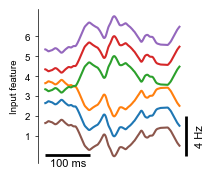

In [62]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(2, 2))

# Plot signals
for i in range(5):
    ax.plot(2*(i+1) + pattern_d1[:, i])
ax.plot(pattern_d1[:, 0])

ax.set_yticks([2, 4, 6, 8, 10, 12])
ax.set_yticklabels([1, 2, 3, 4, 5, 6])
ax.set_ylabel("Input feature")

# Hide top, right, bottom spines but keep left spine
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

# --- Add horizontal bar from 0 to 100 ms at bottom ---

# Time parameters
total_time_ms = 300
time_step_ms = 0.1
samples_100ms = int(100 / time_step_ms)

# Position of horizontal bar in y
# Place below min plotted y-value, e.g. y=0.5 units below axis bottom spine at y=2
x_start = 0
x_end = samples_100ms
  # slightly below first y tick at 2
hbar_y = 0.1
ax.hlines(y=hbar_y, xmin=x_start, xmax=x_end, color='black', linewidth=2)

# Add text label centered on bar
ax.text((x_start + x_end) / 2, hbar_y - 0.3, '100 ms', ha='center', va='top', fontsize=8)

# --- Add vertical line showing frequency 0 to 4 Hz at bottom right ---

# Frequency vertical line position (x near right edge, y from 0 to 4)
vline_x = total_time_ms / time_step_ms * 1.05  # 96% into x axis length
vline_y_start = 0
vline_y_end = 4

ax.vlines(x=vline_x, ymin=vline_y_start, ymax=vline_y_end, color='black', linewidth=2)

# Add text label to the top of vertical line
ax.text(vline_x*1.1, 2 , '4 Hz', ha='center', va='center', fontsize=8, rotation=90)

plt.show()


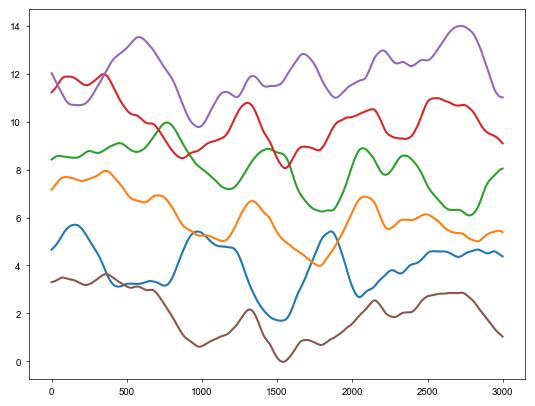

In [30]:
for i in range(5):
    plt.plot(2*(i+1)+pattern_d2[:, i])
plt.plot(pattern_d1[:, 0])

In [21]:
pattern_d2[:, i].min()
pattern_d2[:, i].max()

3.889955113362631

Generating HD input patterns...
Pattern d=1: shape = (3000, 6)
Pattern d=4: shape = (3000, 6)

3D trajectory plot saved!
Channels plotted: 0 and 5
Time range: 0.000 to 0.300 seconds


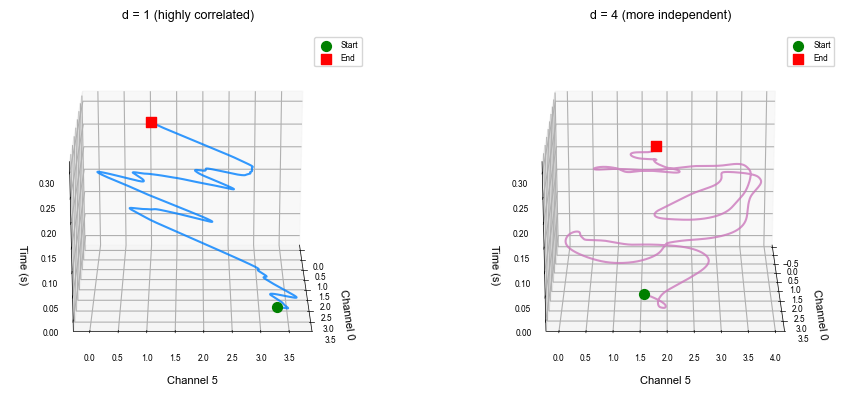


3D comparison plot saved!


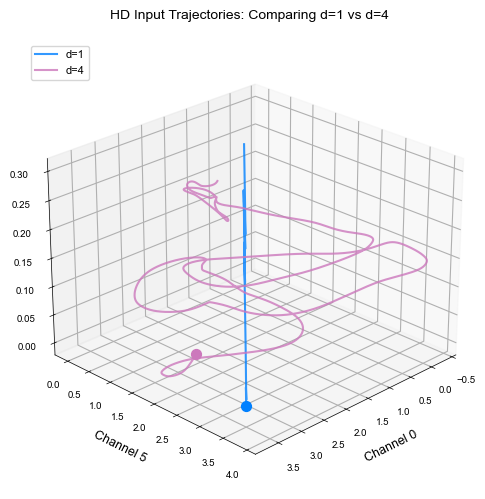

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
import os

# Add project to path
project_root = os.getcwd()
sys.path.insert(0, project_root)

from src.hd_input import HDInputGenerator

# Set matplotlib parameters
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica']
plt.rcParams['font.size'] = 7

# =============================================================================
# GENERATE HD INPUT PATTERNS
# =============================================================================

print("Generating HD input patterns...")

# Parameters
session_id = 120
pattern_id = 0
k = 6  # Embedding dimension
d1 = 1  # Low intrinsic dimensionality
d2 = 4  # High intrinsic dimensionality
dt = 0.1
stimulus_duration = 300.0

# Create generators
gen1 = HDInputGenerator(embed_dim=k, dt=dt, signal_cache_dir='temp_signals_d1')
gen2 = HDInputGenerator(embed_dim=k, dt=dt, signal_cache_dir='temp_signals_d2')

# Generate pattern with d=1
gen1.initialize_base_input(
    session_id=session_id,
    hd_dim=d1,
    pattern_id=pattern_id,
    rate_rnn_params={
        'n_neurons': 1000,
        'T': 200.0 + stimulus_duration,
        'g': 2.0
    }
)
pattern_d1 = gen1.Y_base.copy() + 2

# Generate pattern with d=4
gen2.initialize_base_input(
    session_id=session_id,
    hd_dim=d2,
    pattern_id=pattern_id,
    rate_rnn_params={
        'n_neurons': 1000,
        'T': 200.0 + stimulus_duration,
        'g': 2.0
    }
)
pattern_d2 = gen2.Y_base.copy() + 2

# Time array (in seconds for cleaner plot)
time = np.arange(pattern_d1.shape[0]) * dt / 1000.0  # Convert to seconds

print(f"Pattern d={d1}: shape = {pattern_d1.shape}")
print(f"Pattern d={d2}: shape = {pattern_d2.shape}")

# =============================================================================
# CREATE 3D TRAJECTORY PLOTS
# =============================================================================

# Select channels 0 and 5
ch1 = 0
ch2 = 5

# Create figure with 2 subplots (side by side)
fig = plt.figure(figsize=(10, 4))

# --- SUBPLOT 1: d=1 ---
ax1 = fig.add_subplot(121, projection='3d')

# Plot trajectory
ax1.plot(pattern_d1[:, ch1], pattern_d1[:, ch2], time, 
         linewidth=1.5, color='#0080FF', alpha=0.8)

# Mark start and end
ax1.scatter([pattern_d1[0, ch1]], [pattern_d1[0, ch2]], [time[0]], 
           color='green', s=50, marker='o', label='Start', zorder=5)
ax1.scatter([pattern_d1[-1, ch1]], [pattern_d1[-1, ch2]], [time[-1]], 
           color='red', s=50, marker='s', label='End', zorder=5)

ax1.set_xlabel(f'Channel {ch1}', fontsize=8)
ax1.set_ylabel(f'Channel {ch2}', fontsize=8)
ax1.set_zlabel('Time (s)', fontsize=8)
ax1.set_title(f'd = {d1} (highly correlated)', fontsize=9, pad=10)
ax1.tick_params(labelsize=6)
ax1.legend(fontsize=6)

# Set viewing angle
ax1.view_init(elev=20, azim=0)

# --- SUBPLOT 2: d=4 ---
ax2 = fig.add_subplot(122, projection='3d')

# Plot trajectory
ax2.plot(pattern_d2[:, ch1], pattern_d2[:, ch2], time, 
         linewidth=1.5, color='#CC78BC', alpha=0.8)

# Mark start and end
ax2.scatter([pattern_d2[0, ch1]], [pattern_d2[0, ch2]], [time[0]], 
           color='green', s=50, marker='o', label='Start', zorder=5)
ax2.scatter([pattern_d2[-1, ch1]], [pattern_d2[-1, ch2]], [time[-1]], 
           color='red', s=50, marker='s', label='End', zorder=5)

ax2.set_xlabel(f'Channel {ch1}', fontsize=8)
ax2.set_ylabel(f'Channel {ch2}', fontsize=8)
ax2.set_zlabel('Time (s)', fontsize=8)
ax2.set_title(f'd = {d2} (more independent)', fontsize=9, pad=10)
ax2.tick_params(labelsize=6)
ax2.legend(fontsize=6)

# Set viewing angle
ax2.view_init(elev=20, azim=0)

plt.tight_layout()
plt.savefig('hd_input_3d_trajectories.svg', format='svg', dpi=450, bbox_inches='tight')
plt.savefig('hd_input_3d_trajectories.pdf', format='pdf', dpi=450, bbox_inches='tight')

print("\n3D trajectory plot saved!")
print(f"Channels plotted: {ch1} and {ch2}")
print(f"Time range: {time[0]:.3f} to {time[-1]:.3f} seconds")

plt.show()

# =============================================================================
# ALTERNATIVE: Single 3D plot comparing both
# =============================================================================

fig2 = plt.figure(figsize=(6, 5))
ax = fig2.add_subplot(111, projection='3d')

# Plot both trajectories
ax.plot(pattern_d1[:, ch1], pattern_d1[:, ch2], time, 
        linewidth=1.5, color='#0080FF', alpha=0.8, label=f'd={d1}')
ax.plot(pattern_d2[:, ch1], pattern_d2[:, ch2], time, 
        linewidth=1.5, color='#CC78BC', alpha=0.8, label=f'd={d2}')

# Mark starts
ax.scatter([pattern_d1[0, ch1]], [pattern_d1[0, ch2]], [time[0]], 
          color='#0080FF', s=50, marker='o', zorder=5)
ax.scatter([pattern_d2[0, ch1]], [pattern_d2[0, ch2]], [time[0]], 
          color='#CC78BC', s=50, marker='o', zorder=5)

ax.set_xlabel(f'Channel {ch1}', fontsize=9)
ax.set_ylabel(f'Channel {ch2}', fontsize=9)
ax.set_zlabel('Time (s)', fontsize=9)
ax.set_title('HD Input Trajectories: Comparing d=1 vs d=4', fontsize=10, pad=15)
ax.tick_params(labelsize=7)
ax.legend(fontsize=8, loc='upper left')

# Set viewing angle
ax.view_init(elev=25, azim=45)

plt.tight_layout()
plt.savefig('hd_input_3d_comparison.svg', format='svg', dpi=450, bbox_inches='tight')
plt.savefig('hd_input_3d_comparison.pdf', format='pdf', dpi=450, bbox_inches='tight')

print("\n3D comparison plot saved!")

plt.show()

In [17]:
np.linspace(30,31.6,6)

array([30.  , 30.32, 30.64, 30.96, 31.28, 31.6 ])


CREATING FIGURE

Figure saved as 'nature_figure.svg' and 'nature_figure.pdf'

Figure statistics:
  Panel B: 14970 spikes
  Panel C: Mean firing rate ± std across neurons
  Panel D: Dimensionality (PR) vs g
  Total simulations: 9 g values × 6 rates = 54


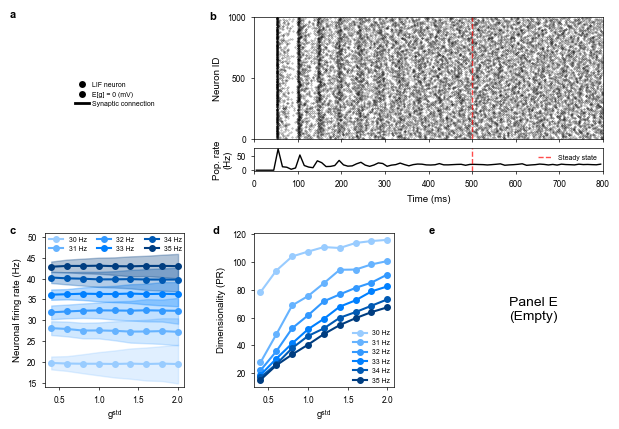

In [34]:

# =============================================================================
# STEP 3: CREATE FIGURE
# =============================================================================

print("\n" + "="*80)
print("CREATING FIGURE")
print("="*80)

# Create figure
fig = plt.figure(figsize=(7.2, 4.8))
main_gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.4, wspace=0.5)

# ROW 1: Cell [0,0] normal, then merged cells [0,1] and [0,2] with two sub-rows (4:1 ratio)
ax_00 = fig.add_subplot(main_gs[0, 0])

row1_gs = gridspec.GridSpecFromSubplotSpec(5, 2, subplot_spec=main_gs[0, 1:3], 
                                            hspace=0.4, wspace=0.1)
ax_01_top = fig.add_subplot(row1_gs[0:4, :])
ax_01_bottom = fig.add_subplot(row1_gs[4, :])

# ROW 2: Normal subplots
ax_10 = fig.add_subplot(main_gs[1, 0])
ax_11 = fig.add_subplot(main_gs[1, 1])
ax_12 = fig.add_subplot(main_gs[1, 2])

# =============================================================================
# PANEL A: Placeholder (you can add your content here)
# =============================================================================


ax_00.axis('off')
ax_00.text(-0.25, 1.05, 'a', transform=ax_00.transAxes, 
           fontsize=8, fontweight='bold', va='top')



# Create custom legend handles (you'll replace these symbols manually in SVG)
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=6, label='LIF neuron'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=6, label='E[g] = 0 (mV)'),
    Line2D([0], [0], color='black', linewidth=2, label='Synaptic connection')
]

ax_00.legend(handles=legend_elements, fontsize=5, frameon=False, 
             loc='center', ncol=1, handletextpad=0.5, borderpad=0)

# =============================================================================
# PANEL B TOP: Raster plot
# =============================================================================

times = [s[0] for s in spike_times_main]
neuron_ids = [s[1] for s in spike_times_main]

ax_01_top.scatter(times, neuron_ids, s=0.1, c='black', alpha=0.5, rasterized=True)
ax_01_top.axvline(transient_time, color='red', linestyle='--', linewidth=1, alpha=0.7)
ax_01_top.set_ylabel('Neuron ID', fontsize=7, verticalalignment='top', labelpad=10)
ax_01_top.set_xlim(0, duration)
ax_01_top.set_ylim(0, n_neurons)
ax_01_top.tick_params(labelsize=6, labelbottom=False)
ax_01_top.text(-0.13, 1.05, 'b', transform=ax_01_top.transAxes, 
               fontsize=8, fontweight='bold', va='top')

ax_01_top.set_yticks([0,500,1000])

# =============================================================================
# PANEL B BOTTOM: Population rate
# =============================================================================

# Use 10ms bins for cleaner population rate plot
bin_size_pop = 10.0
bins = np.arange(0, duration + bin_size_pop, bin_size_pop)
spike_counts, _ = np.histogram(times, bins=bins)
firing_rate = spike_counts / (bin_size_pop / 1000.0) / n_neurons
bin_centers = bins[:-1] + bin_size_pop/2

ax_01_bottom.plot(bin_centers, firing_rate, 'k-', linewidth=1)
ax_01_bottom.axvline(transient_time, color='red', linestyle='--', linewidth=1, label="Steady state", alpha=0.7)
ax_01_bottom.set_xlabel('Time (ms)', fontsize=7)
ax_01_bottom.set_ylabel('Pop. rate\n(Hz)', fontsize=7, verticalalignment='top', labelpad=10)
ax_01_bottom.set_xlim(0, duration)
ax_01_bottom.tick_params(labelsize=6)
ax_01_bottom.legend(fontsize=5, frameon=False, loc='best')

# =============================================================================
# PANEL C: Mean firing rate ± std vs g
# =============================================================================

# Blue gradient from light to dark as input strength increases
import matplotlib.colors as mcolors
colors = ['#99CCFF', '#66B3FF', '#3399FF', '#0080FF', '#0059B3', '#003D80']

for idx, static_rate in enumerate(static_input_rates):
    means = np.array(firing_rate_means[static_rate])
    stds = np.array(firing_rate_stds[static_rate])
    
    ax_10.plot(g_values, means, 'o-', color=colors[idx], linewidth=1.5, 
               markersize=4, label=f'{static_rate} Hz')
    ax_10.fill_between(g_values, means - stds, means + stds, 
                       color=colors[idx], alpha=0.3)

ax_10.set_xlabel('gˢᵗᵈ', fontsize=7)
ax_10.set_ylabel('Neuronal firing rate (Hz)', fontsize=7)
ax_10.tick_params(labelsize=6)
ax_10.set_ylim([14,51])
ax_10.legend(fontsize=5, frameon=False, loc='best', ncol=3, 
             bbox_to_anchor=(1.01, 1.), columnspacing=1.5, borderpad=0)
ax_10.text(-0.25, 1.05, 'c', transform=ax_10.transAxes, 
           fontsize=8, fontweight='bold', va='top')

# =============================================================================
# PANEL D: Dimensionality (PR) vs g
# =============================================================================

for idx, static_rate in enumerate(static_input_rates):
    prs = np.array(dimensionality_data[static_rate])
    
    ax_11.plot(g_values, prs, 'o-', color=colors[idx], linewidth=1.5, 
               markersize=4, label=f'{static_rate} Hz')

ax_11.set_xlabel('gˢᵗᵈ', fontsize=7)
ax_11.set_ylabel('Dimensionality (PR)', fontsize=7)
ax_11.tick_params(labelsize=6)
# ax_11.set_ylim([-1,125])
ax_11.legend(fontsize=5, frameon=False, loc='best', borderpad=0)
ax_11.text(-0.3, 1.05, 'd', transform=ax_11.transAxes, 
           fontsize=8, fontweight='bold', va='top')

# =============================================================================
# PANEL E: Empty for now
# =============================================================================

ax_12.text(0.5, 0.5, 'Panel E\n(Empty)', 
           ha='center', va='center', fontsize=10, transform=ax_12.transAxes)
ax_12.set_xlim(0, 1)
ax_12.set_ylim(0, 1)
ax_12.axis('off')
ax_12.text(-0.25, 1.05, 'e', transform=ax_12.transAxes, 
           fontsize=8, fontweight='bold', va='top')


# =============================================================================
# SAVE FIGURE
# =============================================================================

fig.align_ylabels([ax_01_top,ax_01_bottom])

plt.savefig('nature_figure.svg', format='svg', dpi=450, bbox_inches='tight')
plt.savefig('nature_figure.pdf', format='pdf', dpi=450, bbox_inches='tight')

print("\nFigure saved as 'nature_figure.svg' and 'nature_figure.pdf'")
print("\nFigure statistics:")
print(f"  Panel B: {len(spike_times_main)} spikes")
print(f"  Panel C: Mean firing rate ± std across neurons")
print(f"  Panel D: Dimensionality (PR) vs g")
print(f"  Total simulations: {len(g_values)} g values × {len(static_input_rates)} rates = {len(g_values) * len(static_input_rates)}")

plt.show()

Figure saved as 'nature_figure.svg' and 'nature_figure.pdf'

Key Nature specifications implemented:
✓ Arial/Helvetica font
✓ Font sizes: 5-7 pt
✓ Panel labels: 8pt bold lowercase
✓ Axis labels with units in parentheses
✓ TrueType 42 font embedding
✓ RGB color space
✓ Colorblind-friendly palette
✓ No gridlines, patterns, or drop shadows
✓ Vector format (SVG)


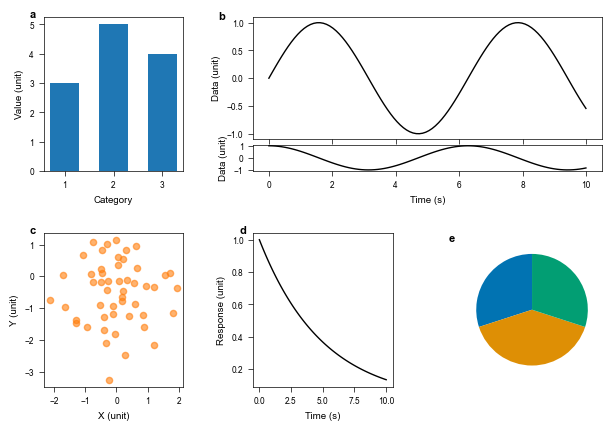

In [8]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Set matplotlib parameters for Nature specifications
plt.rcParams['pdf.fonttype'] = 42  # Ensures TrueType fonts
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica']
plt.rcParams['font.size'] = 7  # Maximum text size per Nature guidelines
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5

# Create figure with appropriate size (Nature single column: 89mm, double: 183mm)
# Using double column width here
fig = plt.figure(figsize=(7.2, 4.8))  # 183mm width, reduced height for 2 rows

# Create main GridSpec for 2 rows
main_gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.4, wspace=0.5)

# ROW 1: Cell [0,0] normal, then merged cells [0,1] and [0,2] with two sub-rows (4:1 ratio)
ax_00 = fig.add_subplot(main_gs[0, 0])

row1_gs = gridspec.GridSpecFromSubplotSpec(5, 2, subplot_spec=main_gs[0, 1:3], 
                                            hspace=0.2, wspace=0.1)
ax_01_top = fig.add_subplot(row1_gs[0:4, :])  # Top 4 parts (merged across columns)
ax_01_bottom = fig.add_subplot(row1_gs[4, :])  # Bottom 1 part (merged across columns)

# ROW 2: Normal subplots
ax_10 = fig.add_subplot(main_gs[1, 0])
ax_11 = fig.add_subplot(main_gs[1, 1])
ax_12 = fig.add_subplot(main_gs[1, 2])

# ============================================================================
# PLACEHOLDER DATA - Replace with your actual data
# ============================================================================

# Example data for demonstration
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)

# Row 1 - Cell [0,0] normal
ax_00.bar([1, 2, 3], [3, 5, 4], color='#1f77b4', width=0.6)
ax_00.set_xlabel('Category', fontsize=7)
ax_00.set_ylabel('Value (unit)', fontsize=7)
ax_00.tick_params(labelsize=6)
ax_00.text(-0.1, 1.05, 'a', transform=ax_00.transAxes, 
           fontsize=8, fontweight='bold', va='top')

# Row 1 - Merged cells [0,1] and [0,2]
ax_01_top.plot(x, y1, 'k-', linewidth=1)
ax_01_top.set_ylabel('Data (unit)', fontsize=7)
ax_01_top.tick_params(labelsize=6)
ax_01_top.text(-0.1, 1.05, 'b', transform=ax_01_top.transAxes, 
               fontsize=8, fontweight='bold', va='top')

ax_01_bottom.plot(x, y2, 'k-', linewidth=1)
ax_01_bottom.set_xlabel('Time (s)', fontsize=7)
ax_01_bottom.set_ylabel('Data (unit)', fontsize=7)
ax_01_bottom.tick_params(labelsize=6)

# Row 2 - Normal cells
ax_10.scatter(np.random.randn(50), np.random.randn(50), 
              c='#ff7f0e', s=20, alpha=0.6)
ax_10.set_xlabel('X (unit)', fontsize=7)
ax_10.set_ylabel('Y (unit)', fontsize=7)
ax_10.tick_params(labelsize=6)
ax_10.text(-0.1, 1.05, 'c', transform=ax_10.transAxes, 
           fontsize=8, fontweight='bold', va='top')

ax_11.plot(x, np.exp(-x/5), 'k-', linewidth=1)
ax_11.set_xlabel('Time (s)', fontsize=7)
ax_11.set_ylabel('Response (unit)', fontsize=7)
ax_11.tick_params(labelsize=6)
ax_11.text(-0.1, 1.05, 'd', transform=ax_11.transAxes, 
           fontsize=8, fontweight='bold', va='top')

# Pie chart with solid colors (Nature recommendation)
colors_colorblind = ['#0173B2', '#DE8F05', '#029E73']  # Colorblind-friendly palette
ax_12.pie([30, 40, 30], colors=colors_colorblind, startangle=90)
ax_12.text(-0.1, 1.05, 'e', transform=ax_12.transAxes, 
           fontsize=8, fontweight='bold', va='top')

# ============================================================================
# SAVE FIGURE
# ============================================================================

# Save as SVG (vector format as recommended by Nature)
plt.savefig('nature_figure.svg', format='svg', dpi=450, bbox_inches='tight')

# Also save as PDF (alternative vector format)
plt.savefig('nature_figure.pdf', format='pdf', dpi=450, bbox_inches='tight')

print("Figure saved as 'nature_figure.svg' and 'nature_figure.pdf'")
print("\nKey Nature specifications implemented:")
print("✓ Arial/Helvetica font")
print("✓ Font sizes: 5-7 pt")
print("✓ Panel labels: 8pt bold lowercase")
print("✓ Axis labels with units in parentheses")
print("✓ TrueType 42 font embedding")
print("✓ RGB color space")
print("✓ Colorblind-friendly palette")
print("✓ No gridlines, patterns, or drop shadows")
print("✓ Vector format (SVG)")

plt.show()